In [1]:
import setGPU
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.utils import shuffle
import h5py
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Anomalous"]

setGPU: Setting GPU to: 0


Using TensorFlow backend.


In [2]:

#Choose where to load the files from
# b_h5 = '/eos/cms/store/user/fsiroky/hdf5_data/'
# b_h5       = '/eos/cms/store/user/fsiroky/lumih5/'
b_h5   = '/afs/cern.ch/user/f/fsiroky/public/'
# b_h5 = '/mnt/hdf5test/'
# b_h5   = '/home/test_local/'

pds  = {1: 'BTagCSV', 2: 'BTagMu', 3: 'Charmonium', 4:'DisplacedJet', 5: 'DoubleEG',
        6: 'DoubleMuon', 7: 'DoubleMuonLowMass',
       # 8: 'FSQJets', 9: 'HighMultiplicityEOF', #NOT ENOUGH DATA, NOTEBOOK FAILES
        10: 'HTMHT', 11: 'JetHT', 12: 'MET',
       # 13: 'MinimumBias', #NOT ENOUGH DATA
        14: 'MuonEG', 15: 'MuOnia',
       # 16: 'NoBPTX',
        17: 'SingleElectron', 18: 'SingleMuon', 19: 'SinglePhoton', 20: 'Tau', 21: 'ZeroBias'
}

#Choose which PD to load
nbr = 12

bg_files  = [b_h5+pds[nbr]+'_C_background.h5',b_h5+pds[nbr]+'_D_background.h5', b_h5+pds[nbr]+'_E_background.h5',
             b_h5+pds[nbr]+'_F_background.h5', b_h5+pds[nbr]+'_G_background.h5', b_h5+pds[nbr]+'_H_background.h5']

bg_jets   = [pds[nbr]+"_C_background", pds[nbr]+"_D_background", pds[nbr]+"_E_background",
             pds[nbr]+"_F_background", pds[nbr]+"_G_background", pds[nbr]+"_H_background"]

sig_files = [b_h5+pds[nbr]+'_C_signal.h5',b_h5+pds[nbr]+'_D_signal.h5', b_h5+pds[nbr]+'_E_signal.h5',
             b_h5+pds[nbr]+'_F_signal.h5', b_h5+pds[nbr]+'_G_signal.h5', b_h5+pds[nbr]+'_H_signal.h5']

sig_jets  = [pds[nbr]+"_C_signal", pds[nbr]+"_D_signal", pds[nbr]+"_E_signal",
             pds[nbr]+"_F_signal", pds[nbr]+"_G_signal", pds[nbr]+"_H_signal"]

      
def get_jets(bg_files, bg_jets, sig_files, sig_jets):
    #Use np.empty([0,2802]) for both good and bad jets, if you use b_h5 = '/eos/cms/store/user/fsiroky/hdf5_data/'
    good_jets = np.empty([0,2806])
    bad_jets  = np.empty([0,2806])
                   # Control which time intervals files per PD to load with range in the for loop
    for i in range(0,len(bg_files)):
        try:
            bg_jetfile  = h5py.File(bg_files[i],'r')
            bg_jet      = bg_jetfile[bg_jets[i]][:]
            sig_jetfile = h5py.File(sig_files[i],'r')
            sig_jet     = sig_jetfile[sig_jets[i]][:]

            bad_jets    = np.concatenate((bad_jets, bg_jet), axis=0)
            good_jets = np.concatenate((good_jets, sig_jet), axis=0)
            print( "Number of good lumis: ", len(sig_jet), " Number of bad lumis: ", len(bg_jet)) 

        except OSError as error:
            print("This Primary Dataset doesn't have ", bg_jets[i], error )
            continue
    return good_jets, bad_jets

In [3]:
#Load good and bad jets
good_jets, bad_jets = get_jets(bg_files, bg_jets, sig_files, sig_jets)

Number of good lumis:  16827  Number of bad lumis:  471
This Primary Dataset doesn't have  MET_D_background Unable to open file (Unable to open file: name = '/afs/cern.ch/user/f/fsiroky/public/met_d_background.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)
Number of good lumis:  24515  Number of bad lumis:  901
Number of good lumis:  16962  Number of bad lumis:  63
Number of good lumis:  41048  Number of bad lumis:  189
This Primary Dataset doesn't have  MET_H_background Unable to open file (Unable to open file: name = '/afs/cern.ch/user/f/fsiroky/public/met_h_background.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)


In [4]:
#Assign good jets class label 0
df1 = pd.DataFrame(good_jets)
# cutted_df = df1.iloc[0:25000, :]   #Temporarily to make training faster
# df1 = cutted_df                   #Temporarily to make training faster
df1['class'] = 0

#Assign bad_jets class label  1
df2 = pd.DataFrame(bad_jets)
# cutted_df = df2.iloc[0:, :]    #Temporarily to make training faster
# df2 = cutted_df                   #Temporarily to make training faster
df2['class'] = 1

# del(good_jets)
# del(bad_jets)
#Concatenate them
frames = [df1,df2]
data   = pd.concat(frames)
del(frames)
# del(df1)
# del(df2)

data.drop(2805, axis=1, inplace=True) #Drop per_pd flags
data = data.sort_values([2800,2801], ascending=[True,True]) #Sort by runID and then by lumiID
data = data.reset_index(drop=True)  #Reset index
runIDs  = data[2800].astype(int)
lumiIDs = data[2801].astype(int)
# data.drop(2800, axis=1, inplace=True) #Drop runIDs not to train on it
# data.drop(2801, axis=1, inplace=True) #Drop lumiIDs not to train on it

data
# data = data.reindex(index=range(0,len(data)))
#Shuffle them randomly
# data = shuffle(data)
# data = data.reset_index(drop=True)

#Save labels and delete them from df not to cheat during training
# labels = data['class'].astype(int)
# del data['class']

,0,1,2,3,4,5,6,7,8,9,...,2796,2797,2798,2799,2800,2801,2802,2803,2804,class
0,13.405186,16.319836,5.000000,7.316654,10.349610,15.171416,1102.536987,-0.001123,2.883613,-5.089836,...,-1.246321,0.0,1.273390,3.141560,275657.0,1.0,0.183,10535.519531,136961.750000,0
1,13.580573,16.431973,5.000009,7.368145,10.537178,15.523487,1982.611450,-0.003457,2.887028,-5.092962,...,-1.237896,0.0,1.293156,3.141552,275657.0,2.0,0.196,10867.347656,141275.515625,0
2,13.450722,16.675581,5.000062,7.332633,10.430347,15.244643,1349.452759,-0.011777,2.884629,-5.099132,...,-1.241357,0.0,1.318202,3.141418,275657.0,3.0,0.196,10566.327148,137362.250000,0
3,13.631460,17.350857,5.000005,7.359198,10.495847,15.446985,1883.230591,0.000298,2.884568,-5.096390,...,-1.240072,0.0,1.283104,3.141560,275657.0,4.0,0.196,10260.204102,133382.656250,0
4,13.310090,18.786495,5.000231,7.239768,10.186782,14.880400,1714.877563,-0.006275,2.879151,-5.089805,...,-1.253762,0.0,1.305805,3.141516,275657.0,18.0,0.210,7690.476562,99976.195312,0
5,13.238980,17.723782,5.000078,7.234935,10.159063,14.746779,985.501282,-0.003002,2.879390,-5.099166,...,-1.233058,0.0,1.273647,3.141482,275657.0,19.0,0.210,7771.428711,101028.578125,0
6,13.202813,18.199722,5.000035,7.220368,10.147364,14.740280,1799.883179,-0.002030,2.872835,-5.096264,...,-1.236394,0.0,1.289665,3.141456,275657.0,20.0,0.209,7775.119141,101076.554688,0
7,13.233785,17.005489,5.000013,7.234465,10.186525,14.802351,1154.270264,-0.015627,2.876822,-5.097066,...,-1.238967,0.0,1.294648,3.141059,275657.0,21.0,0.211,7781.990723,101165.882812,0
8,13.238213,17.890442,5.000001,7.202228,10.078228,14.654392,1343.841919,-0.001154,2.878083,-5.094302,...,-1.264373,0.0,1.287211,3.141484,275657.0,22.0,0.211,8080.568848,105047.398438,0
9,13.203869,17.614918,5.000041,7.217799,10.134926,14.800060,1662.400513,-0.005545,2.876979,-5.096494,...,-1.247604,0.0,1.246975,3.141470,275657.0,23.0,0.211,8047.393555,104616.117188,0


In [5]:
# print((df1[2800]==275778))
var1 = df1.loc[df1[2805] == 0]   #lumis that are GLOBAL:GOOD AND PER_PD:GOOD
print(len(var1))
var2 = df2.loc[df2[2805] == 0] #lumis that are GLOBAL:BAD BUT PER_PD:GOOD 
print(len(var2))
var3 = df1.loc[df1[2805] == 1] #lumis that are GLOBAL:GOOD BUT PER_PD:BAD
print(len(var3))
var4 = df2.loc[df2[2805] == 1] #lumis that are GLOBAL:BAD AND PER_PD:BAD 
print(len(var4))

99155
0
197
1624


# Exploration

In [6]:
# data.iloc[11608:11700,:]

In [7]:
data.isnull().values.any()

False

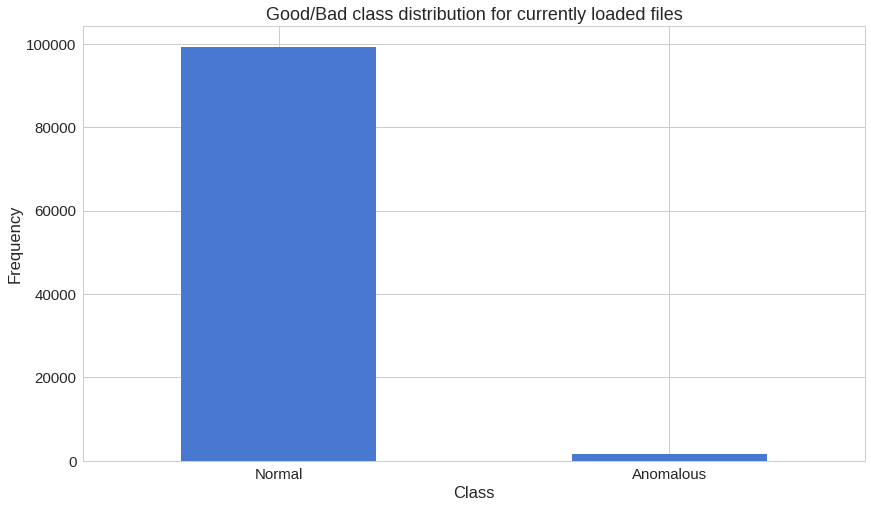

In [8]:
count_classes = pd.value_counts(data['class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)

plt.title("Good/Bad class distribution for currently loaded files")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
# plt.savefig("jetC_StandardScaler_e350_bs1000_ed14_GOODBAD.pdf")

In [9]:
anomalies = data[data['class'] == 1]
normal    = data[data['class'] == 0]

In [10]:
print(anomalies.shape)
del(anomalies)

(1624, 2806)


In [11]:
print(normal.shape)
del(normal)

(99352, 2806)


Let's have a more graphical representation:

# Autoencoders

Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. 

More specifically, let’s take a look at Autoencoder Neural Networks. This autoencoder tries to learn to approximate the following identity function:

$$\textstyle f_{W,b}(x) \approx x$$

While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called *undercomplete*.

Here's a visual representation of what an Autoencoder might learn:

![](http://curiousily.com/assets/12.what_to_do_when_data_is_missing_part_ii_files/mushroom_encoder.png)

## Reconstruction error

We optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized. In practice, the traditional squared error is often used:

$$\textstyle L(x,x') = ||\, x - x'||^2$$

## Train vs validation vs test set

Validation data is not used in the fitting process. This data is not passed to the training process so the optimizer doesnt update the parameters with respect to this data. In autoencoder, this validation_data set (that I will be using later) is used just for calculating the loss function. We often see that we overfit with this specific architecture - we might argue that it is desired since the validation/test set comes from different distribution than train test. That is because train set only contains good lumisection and validation/test contains both good and bad (real life scenario).


# Preparing the data


In [12]:
data.shape

(100976, 2806)

In [13]:
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler

#Normalize the data to make training better
cutted_data = data.iloc[:, 0:2805]
classes     = data.iloc[:, 2805:2806]

# print("Cutted data: ", cutted_data)
# print("Classes : ", classes)
# del(data)

np_scaled = StandardScaler().fit_transform(cutted_data.values)
# datas    = pd.DataFrame(np_scaled)
# np_scaled = cutted_data / cutted_data.max(axis=0)

# np_scaled = MinMaxScaler().fit_transform(cutted_data.values) #Makes wavy normal data

# np_scaled = scale(cutted_data, axis = 0, with_mean=True, with_std=True, copy=True)
datas = pd.DataFrame(np_scaled)

# del(np_scaled)
del(cutted_data)
# print("Datas first: ", datas)
datas['class'] = classes
print(datas)

# print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
# datas = datas.dropna(axis=0, how='any')
# print(datas)
# print("YYYYYYYYYY")
# data = pd.concat([datas, classes])
# print("Datas second: ", datas)

# del(np_scaled)
# print(cutted_data)
# print(classes)

               0         1         2         3         4         5         6  \
0       0.441490 -1.496891 -0.767365  1.273199  1.324259  1.476593  0.049701   
1       0.716987 -1.471395 -0.716059  1.390230  1.519730  1.698861  0.991442   
2       0.513017 -1.416007 -0.375025  1.309516  1.408398  1.522822  0.313918   
3       0.796920 -1.262474 -0.740203  1.369895  1.476657  1.650564  0.885097   
4       0.292114 -0.936060  0.690331  1.098448  1.154569  1.292869  0.704948   
5       0.180416 -1.177684 -0.278449  1.087463  1.125683  1.208512 -0.075535   
6       0.123605 -1.069472 -0.547051  1.054356  1.113490  1.204409  0.795910   
7       0.172254 -1.340998 -0.685879  1.086396  1.154302  1.243596  0.105059   
8       0.179210 -1.139791 -0.761329  1.013125  1.041441  1.150187  0.307914   
9       0.125263 -1.202436 -0.513853  1.048517  1.100528  1.242149  0.648794   
10      0.033464 -1.343852 -0.513853  0.965457  1.008035  1.124849  0.273628   
11      0.224239 -1.155718 -0.559123  1.

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of previously classified lumisections as good. You want to detect any anomaly on new lumisections. We will create this situation by training our model on the normal lumis, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 15% of our data for testing:

In [14]:
# X_train, X_test = train_test_split(datas, test_size=0.15, random_state=RANDOM_SEED) # This works when we split rndmly
split_nbr = round(datas.shape[0]*0.20)  #0.10 means 10% to the validation set

print(datas.shape)
X_train = datas.iloc[0:(datas.shape[0] - split_nbr) ,:]
X_test  = datas.iloc[(datas.shape[0] - split_nbr): (datas.shape[0]) ,:]
print(X_train.shape)
print(X_test.shape)

del(datas)
X_train = X_train[X_train['class']== 0]
print(X_train)
X_train = X_train.drop(['class'], axis=1)

y_test = X_test['class']

print("Number of good lumis in X_test: ", len(X_test[y_test==0]))
print("Number of bad lumis in X_test: ",  len(X_test[y_test==1]))

X_test = X_test.drop(['class'], axis=1)


X_train = X_train.values
X_test = X_test.values

(100976, 2806)
(80781, 2806)
(20195, 2806)
              0         1         2         3         4         5         6  \
0      0.441490 -1.496891 -0.767365  1.273199  1.324259  1.476593  0.049701   
1      0.716987 -1.471395 -0.716059  1.390230  1.519730  1.698861  0.991442   
2      0.513017 -1.416007 -0.375025  1.309516  1.408398  1.522822  0.313918   
3      0.796920 -1.262474 -0.740203  1.369895  1.476657  1.650564  0.885097   
4      0.292114 -0.936060  0.690331  1.098448  1.154569  1.292869  0.704948   
5      0.180416 -1.177684 -0.278449  1.087463  1.125683  1.208512 -0.075535   
6      0.123605 -1.069472 -0.547051  1.054356  1.113490  1.204409  0.795910   
7      0.172254 -1.340998 -0.685879  1.086396  1.154302  1.243596  0.105059   
8      0.179210 -1.139791 -0.761329  1.013125  1.041441  1.150187  0.307914   
9      0.125263 -1.202436 -0.513853  1.048517  1.100528  1.242149  0.648794   
10     0.033464 -1.343852 -0.513853  0.965457  1.008035  1.124849  0.273628   
11     0.

In [15]:
X_train.shape


(79271, 2805)

# Building the model

Our Autoencoder uses 7 fully connected layers with 2000, 1000, 500, 500, 1000, 2000 and 2802  neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 500

In [ ]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(2000, activation="relu" ,
#                 activity_regularizer=regularizers.l1(10e-5)
               )(input_layer)

encoded = Dense(1000, activation='relu')(encoder)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(1000, activation='relu')(encoded)
decoded = Dense(2000, activation='relu')(decoded)
# encoder = Dense(int(encoding_dim / 1.2), activation="relu")(encoder)

# encoder = Dense(int(encoding_dim / 1.5), activation="relu")(encoder)

# decoder = Dense(int(encoding_dim / 1.2), activation='relu')(encoder)

decoder = Dense(input_dim, activation='softmax')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [ ]:
nb_epoch = 30
batch_size = 1000
from keras.optimizers import Adam

adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08, decay = 0.0)
autoencoder.compile(optimizer='adadelta', 
                    loss='binary_crossentropy', 
#                     metrics=['accuracy']
                   )

checkpointer = ModelCheckpoint(filepath="new_datamodelCG.h5",
                               verbose=0,
                               save_best_only=True)
# tensorboard = TensorBoard(log_dir='./logs',
#                           histogram_freq=0,
#                           write_graph=True,
#                           write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=2,
                    callbacks=[checkpointer
#                               ,tensorboard
                              ]).history

In [16]:
autoencoder = load_model('new_datamodelCG.h5')

# Evaluation

In [ ]:
# f = plt.figure()
# plt.plot(history['loss'])
# plt.plot(history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')



# f.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_LOSS.pdf")

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [17]:
predictions = autoencoder.predict(X_test)

In [18]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test})
# print(error_df['true_class']==1)
# print(error_df[error_df['true_class']==1])

# print(89180-80781)
print(error_df)

        reconstruction_error  true_class
80781               1.627912           0
80782               1.647083           0
80783               1.514192           0
80784               1.706799           0
80785               1.444055           0
80786               1.625500           0
80787               1.330905           0
80788               1.647893           0
80789               1.840083           0
80790               1.486333           0
80791               1.627073           0
80792               1.552604           0
80793               1.994224           0
80794               1.896187           0
80795               1.450753           0
80796               1.594765           0
80797               1.550840           0
80798               1.458983           0
80799               1.573956           0
80800               1.493979           0
80801               1.179108           0
80802               1.510716           0
80803               1.231376           0
80804           

In [19]:
pf_jets_list = ['qPFJetPt', 'qPFJetEta', 'qPFJetPhi', 'qPFJet0Pt', 'qPFJet1Pt', 'qPFJet2Pt', 'qPFJet3Pt', 'qPFJet4Pt', 'qPFJet5Pt', 'qPFJet0Eta', 'qPFJet1Eta', 'qPFJet2Eta', 'qPFJet3Eta', 'qPFJet4Eta', 'qPFJet5Eta', 'qPFJet0Phi', 'qPFJet1Phi', 'qPFJet2Phi', 'qPFJet3Phi', 'qPFJet4Phi', 'qPFJet5Phi', 'qPFJet4CHS0Pt', 'qPFJet4CHS1Pt', 'qPFJet4CHS2Pt', 'qPFJet4CHS3Pt', 'qPFJet4CHS4Pt', 'qPFJet4CHS5Pt', 'qPFJet4CHS0Eta', 'qPFJet4CHS1Eta', 'qPFJet4CHS2Eta', 'qPFJet4CHS3Eta', 'qPFJet4CHS4Eta', 'qPFJet4CHS5Eta', 'qPFJet4CHS0Phi', 'qPFJet4CHS1Phi', 'qPFJet4CHS2Phi', 'qPFJet4CHS3Phi', 'qPFJet4CHS4Phi', 'qPFJet4CHS5Phi', 'qPFJet8CHS0Pt', 'qPFJet8CHS1Pt', 'qPFJet8CHS2Pt', 'qPFJet8CHS3Pt', 'qPFJet8CHS4Pt', 'qPFJet8CHS5Pt', 'qPFJet8CHS0Eta', 'qPFJet8CHS1Eta', 'qPFJet8CHS2Eta', 'qPFJet8CHS3Eta', 'qPFJet8CHS4Eta', 'qPFJet8CHS5Eta', 'qPFJet8CHS0Phi', 'qPFJet8CHS1Phi', 'qPFJet8CHS2Phi', 'qPFJet8CHS3Phi', 'qPFJet8CHS4Phi', 'qPFJet8CHS5Phi', 'qPFJetEI0Pt', 'qPFJetEI1Pt', 'qPFJetEI2Pt', 'qPFJetEI3Pt', 'qPFJetEI4Pt', 'qPFJetEI5Pt', 'qPFJetEI0Eta', 'qPFJetEI1Eta', 'qPFJetEI2Eta', 'qPFJetEI3Eta', 'qPFJetEI4Eta', 'qPFJetEI5Eta', 'qPFJetEI0Phi', 'qPFJetEI1Phi', 'qPFJetEI2Phi', 'qPFJetEI3Phi', 'qPFJetEI4Phi', 'qPFJetEI5Phi', 'qPFJet8CHSSD0Pt', 'qPFJet8CHSSD1Pt', 'qPFJet8CHSSD2Pt', 'qPFJet8CHSSD3Pt', 'qPFJet8CHSSD4Pt', 'qPFJet8CHSSD5Pt', 'qPFJet8CHSSD0Eta', 'qPFJet8CHSSD1Eta', 'qPFJet8CHSSD2Eta', 'qPFJet8CHSSD3Eta', 'qPFJet8CHSSD4Eta', 'qPFJet8CHSSD5Eta', 'qPFJet8CHSSD0Phi', 'qPFJet8CHSSD1Phi', 'qPFJet8CHSSD2Phi', 'qPFJet8CHSSD3Phi', 'qPFJet8CHSSD4Phi', 'qPFJet8CHSSD5Phi', 'qPFJetTopCHS0Pt', 'qPFJetTopCHS1Pt', 'qPFJetTopCHS2Pt', 'qPFJetTopCHS3Pt', 'qPFJetTopCHS4Pt', 'qPFJetTopCHS5Pt', 'qPFJetTopCHS0Eta', 'qPFJetTopCHS1Eta', 'qPFJetTopCHS2Eta', 'qPFJetTopCHS3Eta', 'qPFJetTopCHS4Eta', 'qPFJetTopCHS5Eta', 'qPFJetTopCHS0Phi', 'qPFJetTopCHS1Phi', 'qPFJetTopCHS2Phi', 'qPFJetTopCHS3Phi', 'qPFJetTopCHS4Phi', 'qPFJetTopCHS5Phi']
pf_jets=[0,len(pf_jets_list)*7] #COLOUR 1
print(pf_jets, 'pf_jets')
cal_jet_mets_list = ['qCalJet0Pt', 'qCalJet1Pt', 'qCalJet2Pt', 'qCalJet3Pt', 'qCalJet4Pt', 'qCalJet5Pt', 'qCalJet0Eta', 'qCalJet1Eta', 'qCalJet2Eta', 'qCalJet3Eta', 'qCalJet4Eta', 'qCalJet5Eta', 'qCalJet0Phi', 'qCalJet1Phi', 'qCalJet2Phi', 'qCalJet3Phi', 'qCalJet4Phi', 'qCalJet5Phi', 'qCalJet0En', 'qCalJet1En', 'qCalJet2En', 'qCalJet3En', 'qCalJet4En', 'qCalJet5En']
cal_jet_mets=[pf_jets[1]+1, pf_jets[1] + 1 + len(cal_jet_mets_list)*7] #COLOUR 2
print(cal_jet_mets, 'cal_jet_mets')
pho_list = ['qPho0Pt', 'qPho1Pt', 'qPho2Pt', 'qPho3Pt', 'qPho4Pt', 'qPho5Pt', 'qPho0Eta', 'qPho1Eta', 'qPho2Eta', 'qPho3Eta', 'qPho4Eta', 'qPho5Eta', 'qPho0Phi', 'qPho1Phi', 'qPho2Phi', 'qPho3Phi', 'qPho4Phi', 'qPho5Phi', 'qPho0En', 'qPho1En', 'qPho2En', 'qPho3En', 'qPho4En', 'qPho5En', 'qgedPho0Pt', 'qgedPho1Pt', 'qgedPho2Pt', 'qgedPho3Pt', 'qgedPho4Pt', 'qgedPho5Pt', 'qgedPho0Eta', 'qgedPho1Eta', 'qgedPho2Eta', 'qgedPho3Eta', 'qgedPho4Eta', 'qgedPho5Eta', 'qgedPho0Phi', 'qgedPho1Phi', 'qgedPho2Phi', 'qgedPho3Phi', 'qgedPho4Phi', 'qgedPho5Phi', 'qgedPho0En', 'qgedPho1En', 'qgedPho2En', 'qgedPho3En', 'qgedPho4En', 'qgedPho5En']
pho = [cal_jet_mets[1]+1, cal_jet_mets[1]+ 1 + len(pho_list)*7 ] #COLOUR 3
print(pho, 'pho')
muons_list = ['qMu0Pt', 'qMu1Pt', 'qMu2Pt', 'qMu3Pt', 'qMu4Pt', 'qMu5Pt', 'qMu0Eta', 'qMu1Eta', 'qMu2Eta', 'qMu3Eta', 'qMu4Eta', 'qMu5Eta', 'qMu0Phi', 'qMu1Phi', 'qMu2Phi', 'qMu3Phi', 'qMu4Phi', 'qMu5Phi', 'qMu0En', 'qMu1En', 'qMu2En', 'qMu3En', 'qMu4En', 'qMu5En', 'qMuCosm0Pt', 'qMuCosm1Pt', 'qMuCosm2Pt', 'qMuCosm3Pt', 'qMuCosm4Pt', 'qMuCosm5Pt', 'qMuCosm0Eta', 'qMuCosm1Eta', 'qMuCosm2Eta', 'qMuCosm3Eta', 'qMuCosm4Eta', 'qMuCosm5Eta', 'qMuCosm0Phi', 'qMuCosm1Phi', 'qMuCosm2Phi', 'qMuCosm3Phi', 'qMuCosm4Phi', 'qMuCosm5Phi', 'qMuCosm0En', 'qMuCosm1En', 'qMuCosm2En', 'qMuCosm3En', 'qMuCosm4En', 'qMuCosm5En', 'qMuCosmLeg0Pt', 'qMuCosmLeg1Pt', 'qMuCosmLeg2Pt', 'qMuCosmLeg3Pt', 'qMuCosmLeg4Pt', 'qMuCosmLeg5Pt', 'qMuCosmLeg0Eta', 'qMuCosmLeg1Eta', 'qMuCosmLeg2Eta', 'qMuCosmLeg3Eta', 'qMuCosmLeg4Eta', 'qMuCosmLeg5Eta', 'qMuCosmLeg0Phi', 'qMuCosmLeg1Phi', 'qMuCosmLeg2Phi', 'qMuCosmLeg3Phi', 'qMuCosmLeg4Phi', 'qMuCosmLeg5Phi', 'qMuCosmLeg0En', 'qMuCosmLeg1En', 'qMuCosmLeg2En', 'qMuCosmLeg3En', 'qMuCosmLeg4En', 'qMuCosmLeg5En']
muons = [pho[1]+1, pho[1]+1 + len(muons_list)*7] #COLOUR 4
print(muons, 'muons')
pf_jets2_list=['qPFJet4CHSPt', 'qPFJet4CHSEta', 'qPFJet4CHSPhi', 'qPFJet8CHSPt', 'qPFJet8CHSEta', 'qPFJet8CHSPhi', 'qPFJetEIPt', 'qPFJetEIEta', 'qPFJetEIPhi', 'qPFJet8CHSSDPt', 'qPFJet8CHSSDEta', 'qPFJet8CHSSDPhi', 'qPFJetTopCHSPt', 'qPFJetTopCHSEta', 'qPFJetTopCHSPhi']
pf_jets2=[muons[1]+1,muons[1]+1+len(pf_jets2_list)*7] #COLOUR 1 !
print(pf_jets2, 'pf_jets2')
pf_mets_list=['qPFChMetPt', 'qPFChMetPhi', 'qPFMetPt', 'qPFMetPhi']
pf_mets=[pf_jets2[1]+1, pf_jets2[1]+1 + len(pf_mets_list)*7] #COLOUR 5
print(pf_mets, 'pf_mets')
nvtx_list=['qNVtx']
nvtx=[pf_mets[1]+1] #COLOUR 6 (BLACK)
print(nvtx, 'nvtx')
cal_jet_mets2_list = ['qCalJetPt', 'qCalJetEta', 'qCalJetPhi', 'qCalJetEn', 'qCalMETPt', 'qCalMETPhi', 'qCalMETEn', 'qCalMETBEPt', 'qCalMETBEPhi', 'qCalMETBEEn', 'qCalMETBEFOPt', 'qCalMETBEFOPhi', 'qCalMETBEFOEn', 'qCalMETMPt', 'qCalMETMPhi', 'qCalMETMEn']
cal_jet_mets2=[nvtx[0]+1, nvtx[0]+1+len(cal_jet_mets2_list)*7] #COLOUR 7
print(cal_jet_mets2, 'cal_jet_mets2')
sc_list=['qSCEn', 'qSCEta', 'qSCPhi', 'qSCEtaWidth', 'qSCPhiWidth', 'qSCEtahfEM', 'qSCPhihfEM', 'qSCEn5x5', 'qSCEta5x5', 'qSCPhi5x5', 'qSCEtaWidth5x5', 'qSCPhiWidth5x5']
sc=[cal_jet_mets2[1]+1,cal_jet_mets2[1]+1+len(sc_list)*7]#COLOUR 8
print(sc, 'sc')
cc_list=['qCCEn', 'qCCEta', 'qCCPhi', 'qCCEn5x5', 'qCCEta5x5', 'qCCPhi5x5']
cc=[sc[1]+1,sc[1]+1+len(cc_list)*7] #COLOUR 9
print(cc, 'cc')
pho2_list=['qPhoPt', 'qPhoEta', 'qPhoPhi', 'qPhoEn_', 'qPhoe1x5_', 'qPhoe2x5_', 'qPhoe3x3_', 'qPhoe5x5_', 'qPhomaxenxtal_', 'qPhosigmaeta_', 'qPhosigmaIeta_', 'qPhor1x5_', 'qPhor2x5_', 'qPhor9_', 'qgedPhoPt', 'qgedPhoEta', 'qgedPhoPhi', 'qgedPhoEn_', 'qgedPhoe1x5_', 'qgedPhoe2x5_', 'qgedPhoe3x3_', 'qgedPhoe5x5_', 'qgedPhomaxenxtal_', 'qgedPhosigmaeta_', 'qgedPhosigmaIeta_', 'qgedPhor1x5_', 'qgedPhor2x5_', 'qgedPhor9_']
pho2=[cc[1]+1,cc[1]+1+len(pho2_list)*7] #COLOUR 3 !
print(pho2, 'pho2')
muons2_list=['qMuPt', 'qMuEta', 'qMuPhi', 'qMuEn_', 'qMuCh_', 'qMuChi2_', 'qMuCosmPt', 'qMuCosmEta', 'qMuCosmPhi', 'qMuCosmEn_', 'qMuCosmCh_', 'qMuCosmChi2_', 'qMuCosmLegPt', 'qMuCosmLegEta', 'qMuCosmLegPhi', 'qMuCosmLegEn_', 'qMuCosmLegCh_', 'qMuCosmLegChi2_']
muons2=[pho2[1]+1, pho2[1]+1+len(muons2_list)*7]#COLOUR 4 !
print(muons2, 'muons2')
ebs_list=['qSigmaIEta', 'qSigmaIPhi', 'qr9', 'qHadOEm', 'qdrSumPt', 'qdrSumEt', 'qeSCOP', 'qecEn', 'qUNSigmaIEta', 'qUNSigmaIPhi', 'qUNr9', 'qUNHadOEm', 'qUNdrSumPt', 'qUNdrSumEt', 'qUNeSCOP', 'qUNecEn', 'qEBenergy', 'qEBtime', 'qEBchi2', 'qEBiEta', 'qEBiPhi', 'qEEenergy', 'qEEtime', 'qEEchi2', 'qEEix', 'qEEiy', 'qESenergy', 'qEStime', 'qESix', 'qESiy']
ebs=[muons2[1]+1,muons2[1]+1+len(ebs_list)*7] #COLOUR 4
print(ebs, 'ebs')
hbhef_list=['qHBHEenergy', 'qHBHEtime', 'qHBHEauxe', 'qHBHEieta', 'qHBHEiphi', 'qHFenergy', 'qHFtime', 'qHFieta', 'qHFiphi']
hbhef=[ebs[1]+1,ebs[1]+1+len(hbhef_list)*7] #COLOUR 11
print(hbhef, 'hbhef')
presh_list=['qPreShEn', 'qPreShEta', 'qPreShPhi', 'qPreShYEn', 'qPreShYEta', 'qPreShYPhi']
presh=[hbhef[1]+1, hbhef[1]+1+len(presh_list)*7] #COLOUR 12
print(presh, 'presh')


[0, 777] pf_jets
[778, 946] cal_jet_mets
[947, 1283] pho
[1284, 1788] muons
[1789, 1894] pf_jets2
[1895, 1923] pf_mets
[1924] nvtx
[1925, 2037] cal_jet_mets2
[2038, 2122] sc
[2123, 2165] cc
[2166, 2362] pho2
[2363, 2489] muons2
[2490, 2700] ebs
[2701, 2764] hbhef
[2765, 2807] presh


           0         1         2         3         4         5         6     \
0      0.782054  2.222100  0.155351 -1.243100 -1.256515 -1.221676 -0.051107   
1     -0.074095  1.129777  1.223394 -1.295076 -1.304054 -1.279922 -0.418643   
2      0.066702  3.127198  1.933326 -1.294894 -1.302904 -1.325742  1.772165   
3      0.666375  2.565323  1.522788 -1.301029 -1.260026 -1.258492  0.542427   
4      0.279575  1.545979  2.001439 -1.331935 -1.332306 -1.259580 -0.196662   
5      0.452934  1.612833 -0.593195 -1.272321 -1.276815 -1.186737 -0.284546   
6      0.049045  1.910812  0.626153 -1.291204 -1.312490 -1.260666  0.072388   
7      0.397563  2.346326 -0.532434 -1.445495 -1.392539 -1.392843  0.345438   
8      0.143116  1.849353  4.832226 -1.397596 -1.342592 -1.374594  0.108081   
9     -0.363951  0.725993  2.307366 -1.207530 -1.127673 -1.056927 -0.242082   
10     0.003316  2.082369  2.473391 -1.184867 -1.218674 -1.186052  0.450765   
11     0.169912  0.964437 -0.499201 -1.212864 -1.197

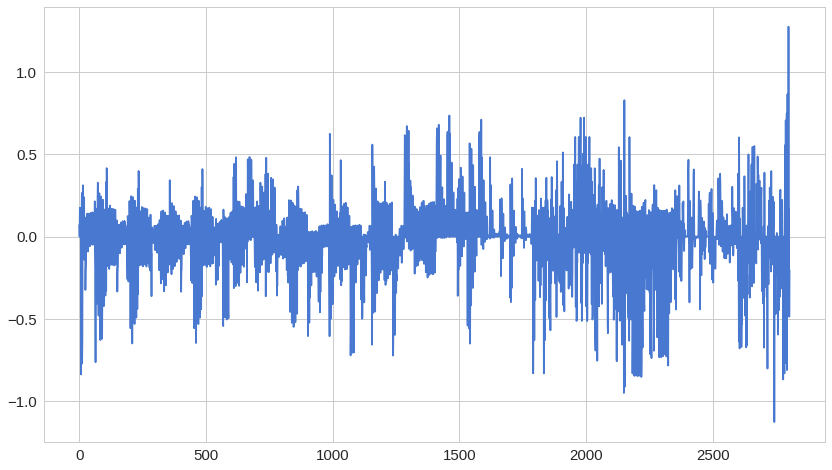

In [20]:
# var_names_reduced5 = ['qPFJetPt', 'qPFJetEta', 'qPFJetPhi', 'qPFJet0Pt', 'qPFJet1Pt', 'qPFJet2Pt', 'qPFJet3Pt', 'qPFJet4Pt', 'qPFJet5Pt', 'qPFJet0Eta', 'qPFJet1Eta', 'qPFJet2Eta', 'qPFJet3Eta', 'qPFJet4Eta', 'qPFJet5Eta', 'qPFJet0Phi', 'qPFJet1Phi', 'qPFJet2Phi', 'qPFJet3Phi', 'qPFJet4Phi', 'qPFJet5Phi', 'qPFJet4CHS0Pt', 'qPFJet4CHS1Pt', 'qPFJet4CHS2Pt', 'qPFJet4CHS3Pt', 'qPFJet4CHS4Pt', 'qPFJet4CHS5Pt', 'qPFJet4CHS0Eta', 'qPFJet4CHS1Eta', 'qPFJet4CHS2Eta', 'qPFJet4CHS3Eta', 'qPFJet4CHS4Eta', 'qPFJet4CHS5Eta', 'qPFJet4CHS0Phi', 'qPFJet4CHS1Phi', 'qPFJet4CHS2Phi', 'qPFJet4CHS3Phi', 'qPFJet4CHS4Phi', 'qPFJet4CHS5Phi', 'qPFJet8CHS0Pt', 'qPFJet8CHS1Pt', 'qPFJet8CHS2Pt', 'qPFJet8CHS3Pt', 'qPFJet8CHS4Pt', 'qPFJet8CHS5Pt', 'qPFJet8CHS0Eta', 'qPFJet8CHS1Eta', 'qPFJet8CHS2Eta', 'qPFJet8CHS3Eta', 'qPFJet8CHS4Eta', 'qPFJet8CHS5Eta', 'qPFJet8CHS0Phi', 'qPFJet8CHS1Phi', 'qPFJet8CHS2Phi', 'qPFJet8CHS3Phi', 'qPFJet8CHS4Phi', 'qPFJet8CHS5Phi', 'qPFJetEI0Pt', 'qPFJetEI1Pt', 'qPFJetEI2Pt', 'qPFJetEI3Pt', 'qPFJetEI4Pt', 'qPFJetEI5Pt', 'qPFJetEI0Eta', 'qPFJetEI1Eta', 'qPFJetEI2Eta', 'qPFJetEI3Eta', 'qPFJetEI4Eta', 'qPFJetEI5Eta', 'qPFJetEI0Phi', 'qPFJetEI1Phi', 'qPFJetEI2Phi', 'qPFJetEI3Phi', 'qPFJetEI4Phi', 'qPFJetEI5Phi', 'qPFJet8CHSSD0Pt', 'qPFJet8CHSSD1Pt', 'qPFJet8CHSSD2Pt', 'qPFJet8CHSSD3Pt', 'qPFJet8CHSSD4Pt', 'qPFJet8CHSSD5Pt', 'qPFJet8CHSSD0Eta', 'qPFJet8CHSSD1Eta', 'qPFJet8CHSSD2Eta', 'qPFJet8CHSSD3Eta', 'qPFJet8CHSSD4Eta', 'qPFJet8CHSSD5Eta', 'qPFJet8CHSSD0Phi', 'qPFJet8CHSSD1Phi', 'qPFJet8CHSSD2Phi', 'qPFJet8CHSSD3Phi', 'qPFJet8CHSSD4Phi', 'qPFJet8CHSSD5Phi', 'qPFJetTopCHS0Pt', 'qPFJetTopCHS1Pt', 'qPFJetTopCHS2Pt', 'qPFJetTopCHS3Pt', 'qPFJetTopCHS4Pt', 'qPFJetTopCHS5Pt', 'qPFJetTopCHS0Eta', 'qPFJetTopCHS1Eta', 'qPFJetTopCHS2Eta', 'qPFJetTopCHS3Eta', 'qPFJetTopCHS4Eta', 'qPFJetTopCHS5Eta', 'qPFJetTopCHS0Phi', 'qPFJetTopCHS1Phi', 'qPFJetTopCHS2Phi', 'qPFJetTopCHS3Phi', 'qPFJetTopCHS4Phi', 'qPFJetTopCHS5Phi', 'qCalJet0Pt', 'qCalJet1Pt', 'qCalJet2Pt', 'qCalJet3Pt', 'qCalJet4Pt', 'qCalJet5Pt', 'qCalJet0Eta', 'qCalJet1Eta', 'qCalJet2Eta', 'qCalJet3Eta', 'qCalJet4Eta', 'qCalJet5Eta', 'qCalJet0Phi', 'qCalJet1Phi', 'qCalJet2Phi', 'qCalJet3Phi', 'qCalJet4Phi', 'qCalJet5Phi', 'qCalJet0En', 'qCalJet1En', 'qCalJet2En', 'qCalJet3En', 'qCalJet4En', 'qCalJet5En', 'qPho0Pt', 'qPho1Pt', 'qPho2Pt', 'qPho3Pt', 'qPho4Pt', 'qPho5Pt', 'qPho0Eta', 'qPho1Eta', 'qPho2Eta', 'qPho3Eta', 'qPho4Eta', 'qPho5Eta', 'qPho0Phi', 'qPho1Phi', 'qPho2Phi', 'qPho3Phi', 'qPho4Phi', 'qPho5Phi', 'qPho0En', 'qPho1En', 'qPho2En', 'qPho3En', 'qPho4En', 'qPho5En', 'qgedPho0Pt', 'qgedPho1Pt', 'qgedPho2Pt', 'qgedPho3Pt', 'qgedPho4Pt', 'qgedPho5Pt', 'qgedPho0Eta', 'qgedPho1Eta', 'qgedPho2Eta', 'qgedPho3Eta', 'qgedPho4Eta', 'qgedPho5Eta', 'qgedPho0Phi', 'qgedPho1Phi', 'qgedPho2Phi', 'qgedPho3Phi', 'qgedPho4Phi', 'qgedPho5Phi', 'qgedPho0En', 'qgedPho1En', 'qgedPho2En', 'qgedPho3En', 'qgedPho4En', 'qgedPho5En', 'qMu0Pt', 'qMu1Pt', 'qMu2Pt', 'qMu3Pt', 'qMu4Pt', 'qMu5Pt', 'qMu0Eta', 'qMu1Eta', 'qMu2Eta', 'qMu3Eta', 'qMu4Eta', 'qMu5Eta', 'qMu0Phi', 'qMu1Phi', 'qMu2Phi', 'qMu3Phi', 'qMu4Phi', 'qMu5Phi', 'qMu0En', 'qMu1En', 'qMu2En', 'qMu3En', 'qMu4En', 'qMu5En', 'qMuCosm0Pt', 'qMuCosm1Pt', 'qMuCosm2Pt', 'qMuCosm3Pt', 'qMuCosm4Pt', 'qMuCosm5Pt', 'qMuCosm0Eta', 'qMuCosm1Eta', 'qMuCosm2Eta', 'qMuCosm3Eta', 'qMuCosm4Eta', 'qMuCosm5Eta', 'qMuCosm0Phi', 'qMuCosm1Phi', 'qMuCosm2Phi', 'qMuCosm3Phi', 'qMuCosm4Phi', 'qMuCosm5Phi', 'qMuCosm0En', 'qMuCosm1En', 'qMuCosm2En', 'qMuCosm3En', 'qMuCosm4En', 'qMuCosm5En', 'qMuCosmLeg0Pt', 'qMuCosmLeg1Pt', 'qMuCosmLeg2Pt', 'qMuCosmLeg3Pt', 'qMuCosmLeg4Pt', 'qMuCosmLeg5Pt', 'qMuCosmLeg0Eta', 'qMuCosmLeg1Eta', 'qMuCosmLeg2Eta', 'qMuCosmLeg3Eta', 'qMuCosmLeg4Eta', 'qMuCosmLeg5Eta', 'qMuCosmLeg0Phi', 'qMuCosmLeg1Phi', 'qMuCosmLeg2Phi', 'qMuCosmLeg3Phi', 'qMuCosmLeg4Phi', 'qMuCosmLeg5Phi', 'qMuCosmLeg0En', 'qMuCosmLeg1En', 'qMuCosmLeg2En', 'qMuCosmLeg3En', 'qMuCosmLeg4En', 'qMuCosmLeg5En', 'qPFJet4CHSPt', 'qPFJet4CHSEta', 'qPFJet4CHSPhi', 'qPFJet8CHSPt', 'qPFJet8CHSEta', 'qPFJet8CHSPhi', 'qPFJetEIPt', 'qPFJetEIEta', 'qPFJetEIPhi', 'qPFJet8CHSSDPt', 'qPFJet8CHSSDEta', 'qPFJet8CHSSDPhi', 'qPFJetTopCHSPt', 'qPFJetTopCHSEta', 'qPFJetTopCHSPhi', 'qPFChMetPt', 'qPFChMetPhi', 'qPFMetPt', 'qPFMetPhi', 'qNVtx', 'qCalJetPt', 'qCalJetEta', 'qCalJetPhi', 'qCalJetEn', 'qCalMETPt', 'qCalMETPhi', 'qCalMETEn', 'qCalMETBEPt', 'qCalMETBEPhi', 'qCalMETBEEn', 'qCalMETBEFOPt', 'qCalMETBEFOPhi', 'qCalMETBEFOEn', 'qCalMETMPt', 'qCalMETMPhi', 'qCalMETMEn', 'qSCEn', 'qSCEta', 'qSCPhi', 'qSCEtaWidth', 'qSCPhiWidth', 'qSCEtahfEM', 'qSCPhihfEM', 'qSCEn5x5', 'qSCEta5x5', 'qSCPhi5x5', 'qSCEtaWidth5x5', 'qSCPhiWidth5x5', 'qCCEn', 'qCCEta', 'qCCPhi', 'qCCEn5x5', 'qCCEta5x5', 'qCCPhi5x5', 'qPhoPt', 'qPhoEta', 'qPhoPhi', 'qPhoEn_', 'qPhoe1x5_', 'qPhoe2x5_', 'qPhoe3x3_', 'qPhoe5x5_', 'qPhomaxenxtal_', 'qPhosigmaeta_', 'qPhosigmaIeta_', 'qPhor1x5_', 'qPhor2x5_', 'qPhor9_', 'qgedPhoPt', 'qgedPhoEta', 'qgedPhoPhi', 'qgedPhoEn_', 'qgedPhoe1x5_', 'qgedPhoe2x5_', 'qgedPhoe3x3_', 'qgedPhoe5x5_', 'qgedPhomaxenxtal_', 'qgedPhosigmaeta_', 'qgedPhosigmaIeta_', 'qgedPhor1x5_', 'qgedPhor2x5_', 'qgedPhor9_', 'qMuPt', 'qMuEta', 'qMuPhi', 'qMuEn_', 'qMuCh_', 'qMuChi2_', 'qMuCosmPt', 'qMuCosmEta', 'qMuCosmPhi', 'qMuCosmEn_', 'qMuCosmCh_', 'qMuCosmChi2_', 'qMuCosmLegPt', 'qMuCosmLegEta', 'qMuCosmLegPhi', 'qMuCosmLegEn_', 'qMuCosmLegCh_', 'qMuCosmLegChi2_', 'qSigmaIEta', 'qSigmaIPhi', 'qr9', 'qHadOEm', 'qdrSumPt', 'qdrSumEt', 'qeSCOP', 'qecEn', 'qUNSigmaIEta', 'qUNSigmaIPhi', 'qUNr9', 'qUNHadOEm', 'qUNdrSumPt', 'qUNdrSumEt', 'qUNeSCOP', 'qUNecEn', 'qEBenergy', 'qEBtime', 'qEBchi2', 'qEBiEta', 'qEBiPhi', 'qEEenergy', 'qEEtime', 'qEEchi2', 'qEEix', 'qEEiy', 'qESenergy', 'qEStime', 'qESix', 'qESiy', 'qHBHEenergy', 'qHBHEtime', 'qHBHEauxe', 'qHBHEieta', 'qHBHEiphi', 'qHFenergy', 'qHFtime', 'qHFieta', 'qHFiphi', 'qPreShEn', 'qPreShEta', 'qPreShPhi', 'qPreShYEn', 'qPreShYEta', 'qPreShYPhi']
# matrix = np.empty([n_good_events,n_vars*7+6])
# for j in range(n_good_events):
#     for i in range(n_vars):
#         matrix[j,i*7:(i+1)*7] = goodEvents[var_list[i]][j]
#     matrix[j,-6] = int(goodEvents['runId'][j])
#     matrix[j,-5] = int(goodEvents['lumiId'][j])
#     matrix[j,-4] = goodEvents['lumi'][j]
#     matrix[j,-3] = goodEvents['crossSection'][j][0]
#     matrix[j,-2] = goodEvents['pathRates'][j][0]
#     matrix[j,-1] = json_checker(output_json, matrix[j,-6], matrix[j,-5])

#THIS CAN MAKE SENSE FOR PLOTTING GOOD ONLY. SEE WHETHER IT IS CONSISTENT!
def mse_plot(X_test, predictions, y_test, mode = None):
    my_vec = []
    for i in range (0,len(X_test)):
        my_vec.append(X_test[i] - predictions[i])
    if mode == "all":
        my_vec = np.array(my_vec)
        pd_vec = pd.DataFrame(my_vec)
        print(pd_vec)
#     elif mode == "good":
#         print("1")
#         new_df = pd.DataFrame({'reconstruction_error': my_vec,
#                                  'true_class': y_test})
#         pd_vec = new_df[(new_df['true_class']== 0)]
#         print(pd_vec)
#     elif mode == "bad":
#         print("2")
    new_vec = []
    for i in range (0, len(X_test[0])):
        new_vec.append(pd_vec[i].mean())
    new_vec = np.array(new_vec)
    new_pd_vec = pd.DataFrame(new_vec)
    incr_vec = []
    for i in range (0, len(X_test[0])):
        incr_vec.append(i)
    incr_vec = np.array(incr_vec)
    plt.plot(incr_vec, new_vec )
    plt.show()
    del(my_vec, new_vec)
    
mse_plot(X_test, predictions, y_test, mode="all")

In [21]:
error_df.describe()
# print(error_df['reconstruction_error'])
print(predictions.shape)
print(mse.shape)

# print(error_df)
#MSE = mean squared error


(20195, 2805)
(20195,)


## Reconstruction error without anomaly

[ 1.6279125   1.64708314  1.5141916  ...,  0.88649225  1.03331526
  0.84471169]


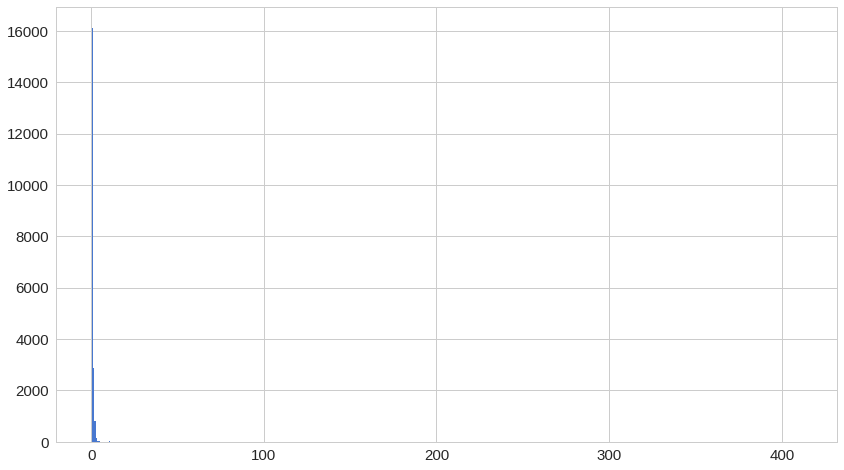

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0)]
print(normal_error_df.reconstruction_error.values)
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=500)
# fig.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_RECERR.pdf")

## Reconstruction error of anomalous lumis

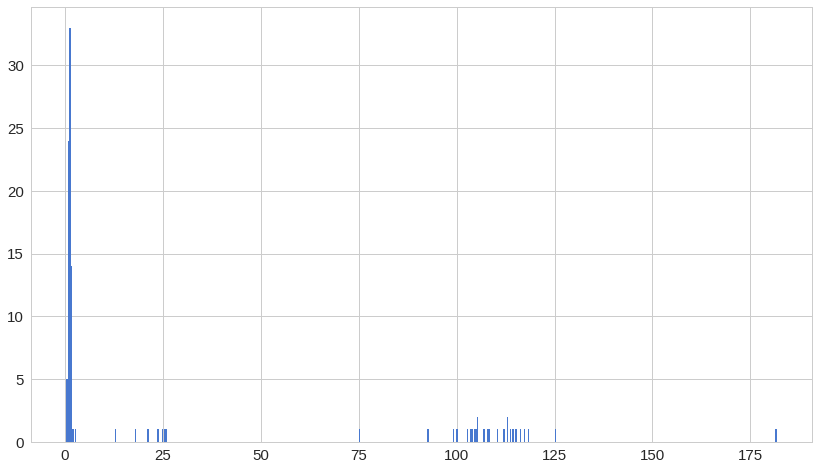

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
anomaly_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(anomaly_error_df.reconstruction_error.values, bins=500)
# fig.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_RECERRANOMALY.pdf")

In [24]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

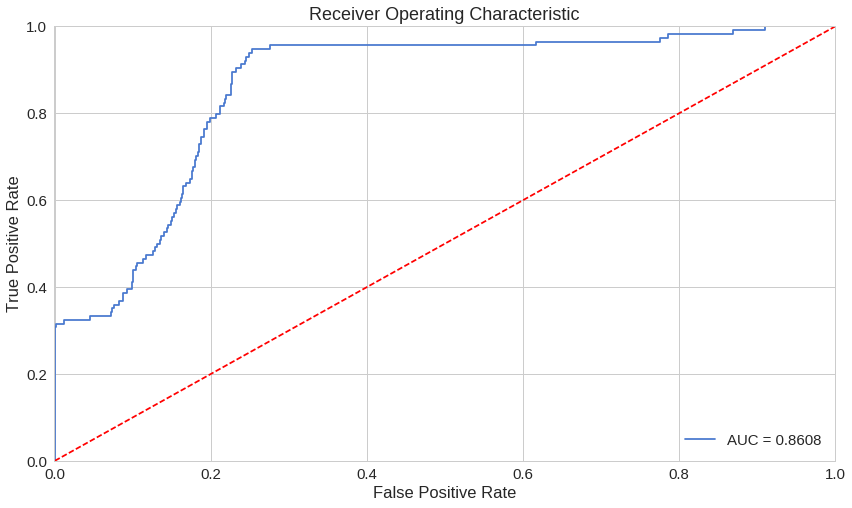

In [25]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# plt.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_ROC.pdf")

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC doesn't look very useful for us. Onward...

## Precision vs Recall

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png" />

Precision and recall are defined as follows:

$$\text{Precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$

$$\text{Recall} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

Let's take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.

Let's return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite - few returned results with very high relevancy. Ideally, you would want high precision and high recall - many results with that are highly relevant.

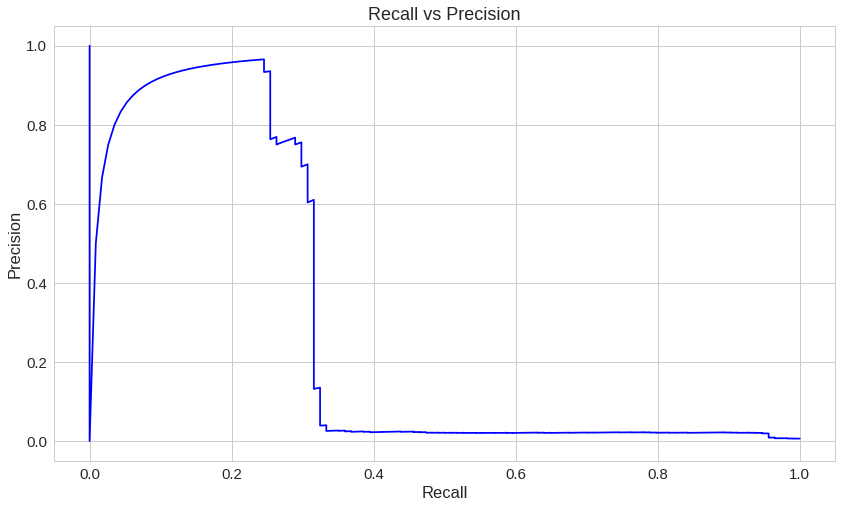

In [26]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
# plt.savefig("jetC_MinMaxScaler_e350_bs1000_ed14__RECPRE.pdf")

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

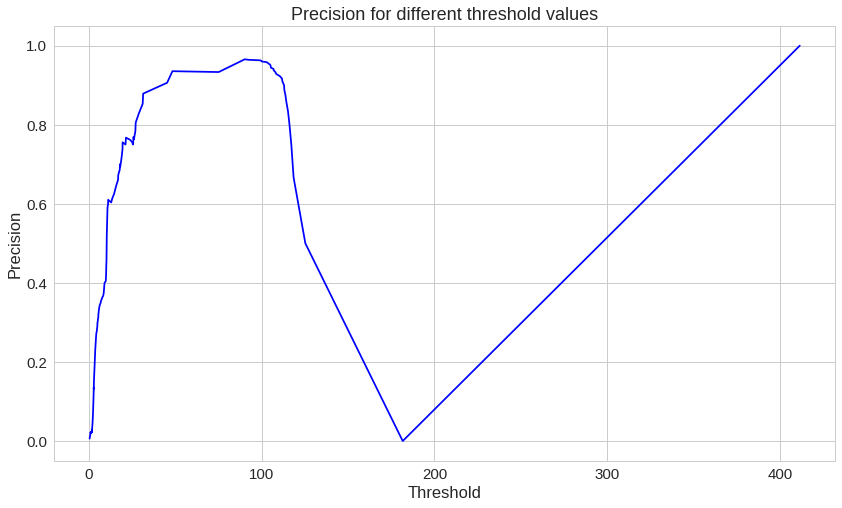

In [27]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()
# plt.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_PRETRE.pdf")

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

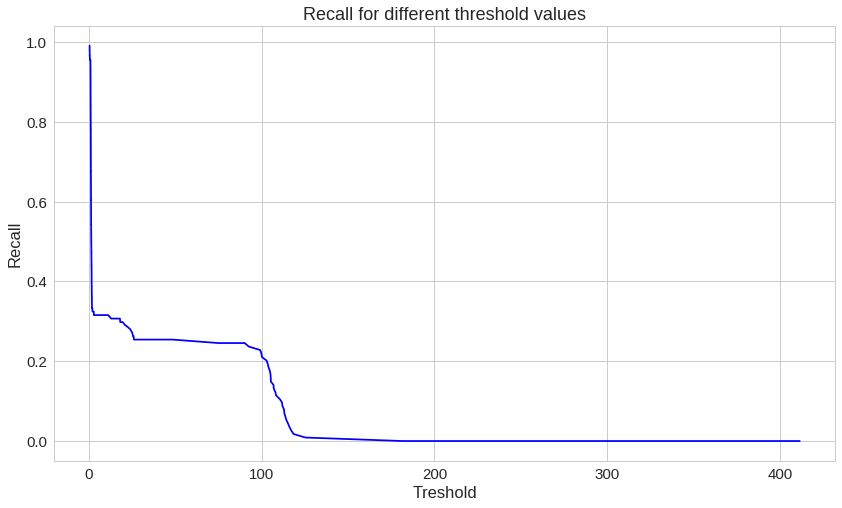

In [28]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Treshold')
plt.ylabel('Recall')
plt.show()
# plt.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_RECTRE.pdf")

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen lumisection is normal or anomalous, we'll calculate the reconstruction error from the lumisection itself. If the error is larger than a predefined threshold, we'll mark it as a anomaly (since our model should have a low error on normal lumisections). Let's pick that value:

In [29]:
threshold = 70

And see how well we're dividing the two types of lumisections:

Actually good lumis with reconstruction error higher than 70
88656     90.215036
99594    411.546125
Name: reconstruction_error, dtype: float64
Actually anomalous lumis with reconstruction error higher than 70
89180    181.695150
89256    110.539040
89257    107.946084
89258    105.160815
89259    114.355792
89260    103.559056
89261    112.083047
89262    118.515683
89263    111.811919
89264    113.138600
89265    108.444611
89266    105.350826
89267    104.805568
89268    100.190719
89269    117.198928
89270    107.041443
89271    102.910317
89272     99.887932
89273    105.295790
89274    106.910642
89275    115.304025
89276    104.064846
89277     75.159476
89278     92.585629
89279     99.212076
89280    113.003958
89281    113.775433
89282    116.143717
89283    125.323509
Name: reconstruction_error, dtype: float64


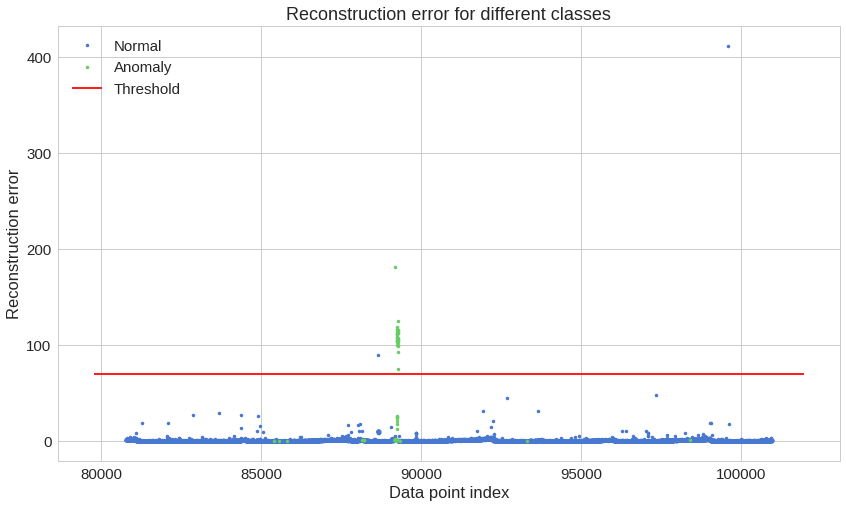

In [36]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    if name == 0:
        print('Actually good lumis with reconstruction error higher than', threshold)
    elif name ==1:
        print('Actually anomalous lumis with reconstruction error higher than', threshold)
    print(group['reconstruction_error'][group['reconstruction_error']>threshold])
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Anomaly" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [45]:
chosen_idx = 88656

print('RunID of chosen lumi:', int(data[2800].ix[chosen_idx]))
print('LumiID of chosen lumi:',int(data[2801].ix[chosen_idx]))

RunID of chosen lumi: 279975
LumiID of chosen lumi: 708


chosen_idx is:  88656


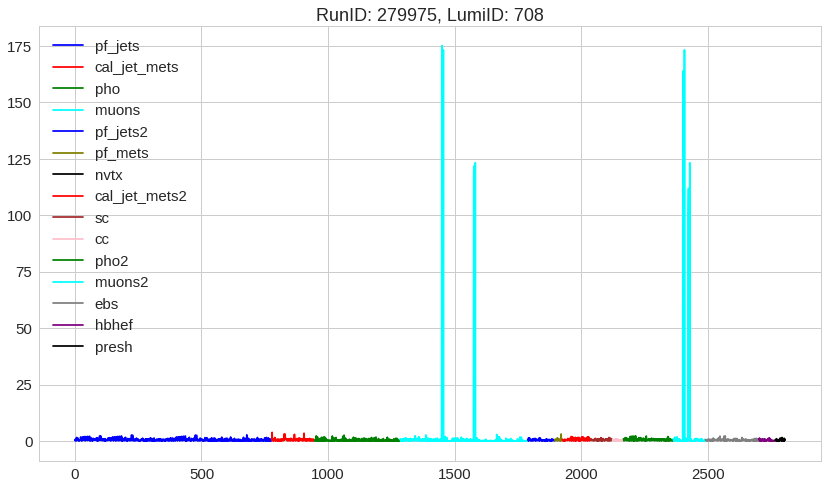

In [46]:
if 'chosen_idx' in globals():
    print('chosen_idx is: ', chosen_idx)
else:
    chosen_idx = 1
    print('temporarily chosen_idx is: ', chosen_idx)
    
    
testset_idx = chosen_idx - 80781    #because 80780 is last index of training lumisection
# print(X_test[0] - predictions[0])
my_vec = X_test[testset_idx] - predictions[testset_idx]

                
my_vec = np.array(abs(my_vec))
pd_vec = pd.DataFrame(my_vec)

incr_vec = []
for i in range (0,2805):
    incr_vec.append(i)
incr_vec = np.array(incr_vec)

plt.plot(incr_vec[0:777],     pd_vec[0:777],     color='blue')          #pf_jets
plt.plot(incr_vec[778:946],   pd_vec[778:946],   color='red')           #cal_jet_mets
plt.plot(incr_vec[947:1283],  pd_vec[947:1283],  color='green')         #pho
plt.plot(incr_vec[1284:1788], pd_vec[1284:1788], color='cyan')          #muons
plt.plot(incr_vec[1789:1894], pd_vec[1789:1894], color='blue')          #pf_jets2
plt.plot(incr_vec[1895:1923], pd_vec[1895:1923], color='olive')         #pf_mets
plt.plot(incr_vec[1924:1925], pd_vec[1924:1925], color='black')         #nvtx
plt.plot(incr_vec[1925:2037], pd_vec[1925:2037], color='red')           #cal_jet_mets2
plt.plot(incr_vec[2038:2122], pd_vec[2038:2122], color='brown')         #sc
plt.plot(incr_vec[2123:2165], pd_vec[2123:2165], color='pink')          #cc
plt.plot(incr_vec[2166:2362], pd_vec[2166:2362], color='green')         #pho2
plt.plot(incr_vec[2363:2489], pd_vec[2363:2489], color='cyan')          #muons2
plt.plot(incr_vec[2490:2700], pd_vec[2490:2700], color='gray')          #ebs
plt.plot(incr_vec[2701:2764], pd_vec[2701:2764], color='purple')        #hbhef
plt.plot(incr_vec[2765:2807], pd_vec[2765:2807], color='black')         #presh


plt.legend(['pf_jets', 'cal_jet_mets', 'pho', 'muons', 'pf_jets2', 'pf_mets', 'nvtx', 
           'cal_jet_mets2', 'sc', 'cc', 'pho2', 'muons2', 'ebs', 'hbhef', 'presh'], loc='best')

plt.title('RunID: '+ str(int(data[2800].ix[chosen_idx]))+', '+ 'LumiID: '+ str(int(data[2801].ix[chosen_idx])))

plt.show()
# print(kokonat.shape)

# var_names_reduced5 = ['qPFJetPt', 'qPFJetEta', 'qPFJetPhi', 'qPFJet0Pt', 'qPFJet1Pt', 'qPFJet2Pt', 'qPFJet3Pt', 'qPFJet4Pt', 'qPFJet5Pt', 'qPFJet0Eta', 'qPFJet1Eta', 'qPFJet2Eta', 'qPFJet3Eta', 'qPFJet4Eta', 'qPFJet5Eta', 'qPFJet0Phi', 'qPFJet1Phi', 'qPFJet2Phi', 'qPFJet3Phi', 'qPFJet4Phi', 'qPFJet5Phi', 'qPFJet4CHS0Pt', 'qPFJet4CHS1Pt', 'qPFJet4CHS2Pt', 'qPFJet4CHS3Pt', 'qPFJet4CHS4Pt', 'qPFJet4CHS5Pt', 'qPFJet4CHS0Eta', 'qPFJet4CHS1Eta', 'qPFJet4CHS2Eta', 'qPFJet4CHS3Eta', 'qPFJet4CHS4Eta', 'qPFJet4CHS5Eta', 'qPFJet4CHS0Phi', 'qPFJet4CHS1Phi', 'qPFJet4CHS2Phi', 'qPFJet4CHS3Phi', 'qPFJet4CHS4Phi', 'qPFJet4CHS5Phi', 'qPFJet8CHS0Pt', 'qPFJet8CHS1Pt', 'qPFJet8CHS2Pt', 'qPFJet8CHS3Pt', 'qPFJet8CHS4Pt', 'qPFJet8CHS5Pt', 'qPFJet8CHS0Eta', 'qPFJet8CHS1Eta', 'qPFJet8CHS2Eta', 'qPFJet8CHS3Eta', 'qPFJet8CHS4Eta', 'qPFJet8CHS5Eta', 'qPFJet8CHS0Phi', 'qPFJet8CHS1Phi', 'qPFJet8CHS2Phi', 'qPFJet8CHS3Phi', 'qPFJet8CHS4Phi', 'qPFJet8CHS5Phi', 'qPFJetEI0Pt', 'qPFJetEI1Pt', 'qPFJetEI2Pt', 'qPFJetEI3Pt', 'qPFJetEI4Pt', 'qPFJetEI5Pt', 'qPFJetEI0Eta', 'qPFJetEI1Eta', 'qPFJetEI2Eta', 'qPFJetEI3Eta', 'qPFJetEI4Eta', 'qPFJetEI5Eta', 'qPFJetEI0Phi', 'qPFJetEI1Phi', 'qPFJetEI2Phi', 'qPFJetEI3Phi', 'qPFJetEI4Phi', 'qPFJetEI5Phi', 'qPFJet8CHSSD0Pt', 'qPFJet8CHSSD1Pt', 'qPFJet8CHSSD2Pt', 'qPFJet8CHSSD3Pt', 'qPFJet8CHSSD4Pt', 'qPFJet8CHSSD5Pt', 'qPFJet8CHSSD0Eta', 'qPFJet8CHSSD1Eta', 'qPFJet8CHSSD2Eta', 'qPFJet8CHSSD3Eta', 'qPFJet8CHSSD4Eta', 'qPFJet8CHSSD5Eta', 'qPFJet8CHSSD0Phi', 'qPFJet8CHSSD1Phi', 'qPFJet8CHSSD2Phi', 'qPFJet8CHSSD3Phi', 'qPFJet8CHSSD4Phi', 'qPFJet8CHSSD5Phi', 'qPFJetTopCHS0Pt', 'qPFJetTopCHS1Pt', 'qPFJetTopCHS2Pt', 'qPFJetTopCHS3Pt', 'qPFJetTopCHS4Pt', 'qPFJetTopCHS5Pt', 'qPFJetTopCHS0Eta', 'qPFJetTopCHS1Eta', 'qPFJetTopCHS2Eta', 'qPFJetTopCHS3Eta', 'qPFJetTopCHS4Eta', 'qPFJetTopCHS5Eta', 'qPFJetTopCHS0Phi', 'qPFJetTopCHS1Phi', 'qPFJetTopCHS2Phi', 'qPFJetTopCHS3Phi', 'qPFJetTopCHS4Phi', 'qPFJetTopCHS5Phi', 'qCalJet0Pt', 'qCalJet1Pt', 'qCalJet2Pt', 'qCalJet3Pt', 'qCalJet4Pt', 'qCalJet5Pt', 'qCalJet0Eta', 'qCalJet1Eta', 'qCalJet2Eta', 'qCalJet3Eta', 'qCalJet4Eta', 'qCalJet5Eta', 'qCalJet0Phi', 'qCalJet1Phi', 'qCalJet2Phi', 'qCalJet3Phi', 'qCalJet4Phi', 'qCalJet5Phi', 'qCalJet0En', 'qCalJet1En', 'qCalJet2En', 'qCalJet3En', 'qCalJet4En', 'qCalJet5En', 'qPho0Pt', 'qPho1Pt', 'qPho2Pt', 'qPho3Pt', 'qPho4Pt', 'qPho5Pt', 'qPho0Eta', 'qPho1Eta', 'qPho2Eta', 'qPho3Eta', 'qPho4Eta', 'qPho5Eta', 'qPho0Phi', 'qPho1Phi', 'qPho2Phi', 'qPho3Phi', 'qPho4Phi', 'qPho5Phi', 'qPho0En', 'qPho1En', 'qPho2En', 'qPho3En', 'qPho4En', 'qPho5En', 'qgedPho0Pt', 'qgedPho1Pt', 'qgedPho2Pt', 'qgedPho3Pt', 'qgedPho4Pt', 'qgedPho5Pt', 'qgedPho0Eta', 'qgedPho1Eta', 'qgedPho2Eta', 'qgedPho3Eta', 'qgedPho4Eta', 'qgedPho5Eta', 'qgedPho0Phi', 'qgedPho1Phi', 'qgedPho2Phi', 'qgedPho3Phi', 'qgedPho4Phi', 'qgedPho5Phi', 'qgedPho0En', 'qgedPho1En', 'qgedPho2En', 'qgedPho3En', 'qgedPho4En', 'qgedPho5En', 'qMu0Pt', 'qMu1Pt', 'qMu2Pt', 'qMu3Pt', 'qMu4Pt', 'qMu5Pt', 'qMu0Eta', 'qMu1Eta', 'qMu2Eta', 'qMu3Eta', 'qMu4Eta', 'qMu5Eta', 'qMu0Phi', 'qMu1Phi', 'qMu2Phi', 'qMu3Phi', 'qMu4Phi', 'qMu5Phi', 'qMu0En', 'qMu1En', 'qMu2En', 'qMu3En', 'qMu4En', 'qMu5En', 'qMuCosm0Pt', 'qMuCosm1Pt', 'qMuCosm2Pt', 'qMuCosm3Pt', 'qMuCosm4Pt', 'qMuCosm5Pt', 'qMuCosm0Eta', 'qMuCosm1Eta', 'qMuCosm2Eta', 'qMuCosm3Eta', 'qMuCosm4Eta', 'qMuCosm5Eta', 'qMuCosm0Phi', 'qMuCosm1Phi', 'qMuCosm2Phi', 'qMuCosm3Phi', 'qMuCosm4Phi', 'qMuCosm5Phi', 'qMuCosm0En', 'qMuCosm1En', 'qMuCosm2En', 'qMuCosm3En', 'qMuCosm4En', 'qMuCosm5En', 'qMuCosmLeg0Pt', 'qMuCosmLeg1Pt', 'qMuCosmLeg2Pt', 'qMuCosmLeg3Pt', 'qMuCosmLeg4Pt', 'qMuCosmLeg5Pt', 'qMuCosmLeg0Eta', 'qMuCosmLeg1Eta', 'qMuCosmLeg2Eta', 'qMuCosmLeg3Eta', 'qMuCosmLeg4Eta', 'qMuCosmLeg5Eta', 'qMuCosmLeg0Phi', 'qMuCosmLeg1Phi', 'qMuCosmLeg2Phi', 'qMuCosmLeg3Phi', 'qMuCosmLeg4Phi', 'qMuCosmLeg5Phi', 'qMuCosmLeg0En', 'qMuCosmLeg1En', 'qMuCosmLeg2En', 'qMuCosmLeg3En', 'qMuCosmLeg4En', 'qMuCosmLeg5En', 'qPFJet4CHSPt', 'qPFJet4CHSEta', 'qPFJet4CHSPhi', 'qPFJet8CHSPt', 'qPFJet8CHSEta', 'qPFJet8CHSPhi', 'qPFJetEIPt', 'qPFJetEIEta', 'qPFJetEIPhi', 'qPFJet8CHSSDPt', 'qPFJet8CHSSDEta', 'qPFJet8CHSSDPhi', 'qPFJetTopCHSPt', 'qPFJetTopCHSEta', 'qPFJetTopCHSPhi', 'qPFChMetPt', 'qPFChMetPhi', 'qPFMetPt', 'qPFMetPhi', 'qNVtx', 'qCalJetPt', 'qCalJetEta', 'qCalJetPhi', 'qCalJetEn', 'qCalMETPt', 'qCalMETPhi', 'qCalMETEn', 'qCalMETBEPt', 'qCalMETBEPhi', 'qCalMETBEEn', 'qCalMETBEFOPt', 'qCalMETBEFOPhi', 'qCalMETBEFOEn', 'qCalMETMPt', 'qCalMETMPhi', 'qCalMETMEn', 'qSCEn', 'qSCEta', 'qSCPhi', 'qSCEtaWidth', 'qSCPhiWidth', 'qSCEtahfEM', 'qSCPhihfEM', 'qSCEn5x5', 'qSCEta5x5', 'qSCPhi5x5', 'qSCEtaWidth5x5', 'qSCPhiWidth5x5', 'qCCEn', 'qCCEta', 'qCCPhi', 'qCCEn5x5', 'qCCEta5x5', 'qCCPhi5x5', 'qPhoPt', 'qPhoEta', 'qPhoPhi', 'qPhoEn_', 'qPhoe1x5_', 'qPhoe2x5_', 'qPhoe3x3_', 'qPhoe5x5_', 'qPhomaxenxtal_', 'qPhosigmaeta_', 'qPhosigmaIeta_', 'qPhor1x5_', 'qPhor2x5_', 'qPhor9_', 'qgedPhoPt', 'qgedPhoEta', 'qgedPhoPhi', 'qgedPhoEn_', 'qgedPhoe1x5_', 'qgedPhoe2x5_', 'qgedPhoe3x3_', 'qgedPhoe5x5_', 'qgedPhomaxenxtal_', 'qgedPhosigmaeta_', 'qgedPhosigmaIeta_', 'qgedPhor1x5_', 'qgedPhor2x5_', 'qgedPhor9_', 'qMuPt', 'qMuEta', 'qMuPhi', 'qMuEn_', 'qMuCh_', 'qMuChi2_', 'qMuCosmPt', 'qMuCosmEta', 'qMuCosmPhi', 'qMuCosmEn_', 'qMuCosmCh_', 'qMuCosmChi2_', 'qMuCosmLegPt', 'qMuCosmLegEta', 'qMuCosmLegPhi', 'qMuCosmLegEn_', 'qMuCosmLegCh_', 'qMuCosmLegChi2_', 'qSigmaIEta', 'qSigmaIPhi', 'qr9', 'qHadOEm', 'qdrSumPt', 'qdrSumEt', 'qeSCOP', 'qecEn', 'qUNSigmaIEta', 'qUNSigmaIPhi', 'qUNr9', 'qUNHadOEm', 'qUNdrSumPt', 'qUNdrSumEt', 'qUNeSCOP', 'qUNecEn', 'qEBenergy', 'qEBtime', 'qEBchi2', 'qEBiEta', 'qEBiPhi', 'qEEenergy', 'qEEtime', 'qEEchi2', 'qEEix', 'qEEiy', 'qESenergy', 'qEStime', 'qESix', 'qESiy', 'qHBHEenergy', 'qHBHEtime', 'qHBHEauxe', 'qHBHEieta', 'qHBHEiphi', 'qHFenergy', 'qHFtime', 'qHFieta', 'qHFiphi', 'qPreShEn', 'qPreShEta', 'qPreShPhi', 'qPreShYEn', 'qPreShYEta', 'qPreShYPhi']
# test_novej         = ['qPFJetPt', 'qPFJetEta', 'qPFJetPhi', 'qPFJet0Pt', 'qPFJet1Pt', 'qPFJet2Pt', 'qPFJet3Pt', 'qPFJet4Pt', 'qPFJet5Pt', 'qPFJet0Eta', 'qPFJet1Eta', 'qPFJet2Eta', 'qPFJet3Eta', 'qPFJet4Eta', 'qPFJet5Eta', 'qPFJet0Phi', 'qPFJet1Phi', 'qPFJet2Phi', 'qPFJet3Phi', 'qPFJet4Phi', 'qPFJet5Phi', 'qPFJet4CHS0Pt', 'qPFJet4CHS1Pt', 'qPFJet4CHS2Pt', 'qPFJet4CHS3Pt', 'qPFJet4CHS4Pt', 'qPFJet4CHS5Pt', 'qPFJet4CHS0Eta', 'qPFJet4CHS1Eta', 'qPFJet4CHS2Eta', 'qPFJet4CHS3Eta', 'qPFJet4CHS4Eta', 'qPFJet4CHS5Eta', 'qPFJet4CHS0Phi', 'qPFJet4CHS1Phi', 'qPFJet4CHS2Phi', 'qPFJet4CHS3Phi', 'qPFJet4CHS4Phi', 'qPFJet4CHS5Phi', 'qPFJet8CHS0Pt', 'qPFJet8CHS1Pt', 'qPFJet8CHS2Pt', 'qPFJet8CHS3Pt', 'qPFJet8CHS4Pt', 'qPFJet8CHS5Pt', 'qPFJet8CHS0Eta', 'qPFJet8CHS1Eta', 'qPFJet8CHS2Eta', 'qPFJet8CHS3Eta', 'qPFJet8CHS4Eta', 'qPFJet8CHS5Eta', 'qPFJet8CHS0Phi', 'qPFJet8CHS1Phi', 'qPFJet8CHS2Phi', 'qPFJet8CHS3Phi', 'qPFJet8CHS4Phi', 'qPFJet8CHS5Phi', 'qPFJetEI0Pt', 'qPFJetEI1Pt', 'qPFJetEI2Pt', 'qPFJetEI3Pt', 'qPFJetEI4Pt', 'qPFJetEI5Pt', 'qPFJetEI0Eta', 'qPFJetEI1Eta', 'qPFJetEI2Eta', 'qPFJetEI3Eta', 'qPFJetEI4Eta', 'qPFJetEI5Eta', 'qPFJetEI0Phi', 'qPFJetEI1Phi', 'qPFJetEI2Phi', 'qPFJetEI3Phi', 'qPFJetEI4Phi', 'qPFJetEI5Phi', 'qPFJet8CHSSD0Pt', 'qPFJet8CHSSD1Pt', 'qPFJet8CHSSD2Pt', 'qPFJet8CHSSD3Pt', 'qPFJet8CHSSD4Pt', 'qPFJet8CHSSD5Pt', 'qPFJet8CHSSD0Eta', 'qPFJet8CHSSD1Eta', 'qPFJet8CHSSD2Eta', 'qPFJet8CHSSD3Eta', 'qPFJet8CHSSD4Eta', 'qPFJet8CHSSD5Eta', 'qPFJet8CHSSD0Phi', 'qPFJet8CHSSD1Phi', 'qPFJet8CHSSD2Phi', 'qPFJet8CHSSD3Phi', 'qPFJet8CHSSD4Phi', 'qPFJet8CHSSD5Phi', 'qPFJetTopCHS0Pt', 'qPFJetTopCHS1Pt', 'qPFJetTopCHS2Pt', 'qPFJetTopCHS3Pt', 'qPFJetTopCHS4Pt', 'qPFJetTopCHS5Pt', 'qPFJetTopCHS0Eta', 'qPFJetTopCHS1Eta', 'qPFJetTopCHS2Eta', 'qPFJetTopCHS3Eta', 'qPFJetTopCHS4Eta', 'qPFJetTopCHS5Eta', 'qPFJetTopCHS0Phi', 'qPFJetTopCHS1Phi', 'qPFJetTopCHS2Phi', 'qPFJetTopCHS3Phi', 'qPFJetTopCHS4Phi', 'qPFJetTopCHS5Phi', 'qCalJet0Pt', 'qCalJet1Pt', 'qCalJet2Pt', 'qCalJet3Pt', 'qCalJet4Pt', 'qCalJet5Pt', 'qCalJet0Eta', 'qCalJet1Eta', 'qCalJet2Eta', 'qCalJet3Eta', 'qCalJet4Eta', 'qCalJet5Eta', 'qCalJet0Phi', 'qCalJet1Phi', 'qCalJet2Phi', 'qCalJet3Phi', 'qCalJet4Phi', 'qCalJet5Phi', 'qCalJet0En', 'qCalJet1En', 'qCalJet2En', 'qCalJet3En', 'qCalJet4En', 'qCalJet5En', 'qPho0Pt', 'qPho1Pt', 'qPho2Pt', 'qPho3Pt', 'qPho4Pt', 'qPho5Pt', 'qPho0Eta', 'qPho1Eta', 'qPho2Eta', 'qPho3Eta', 'qPho4Eta', 'qPho5Eta', 'qPho0Phi', 'qPho1Phi', 'qPho2Phi', 'qPho3Phi', 'qPho4Phi', 'qPho5Phi', 'qPho0En', 'qPho1En', 'qPho2En', 'qPho3En', 'qPho4En', 'qPho5En', 'qgedPho0Pt', 'qgedPho1Pt', 'qgedPho2Pt', 'qgedPho3Pt', 'qgedPho4Pt', 'qgedPho5Pt', 'qgedPho0Eta', 'qgedPho1Eta', 'qgedPho2Eta', 'qgedPho3Eta', 'qgedPho4Eta', 'qgedPho5Eta', 'qgedPho0Phi', 'qgedPho1Phi', 'qgedPho2Phi', 'qgedPho3Phi', 'qgedPho4Phi', 'qgedPho5Phi', 'qgedPho0En', 'qgedPho1En', 'qgedPho2En', 'qgedPho3En', 'qgedPho4En', 'qgedPho5En', 'qMu0Pt', 'qMu1Pt', 'qMu2Pt', 'qMu3Pt', 'qMu4Pt', 'qMu5Pt', 'qMu0Eta', 'qMu1Eta', 'qMu2Eta', 'qMu3Eta', 'qMu4Eta', 'qMu5Eta', 'qMu0Phi', 'qMu1Phi', 'qMu2Phi', 'qMu3Phi', 'qMu4Phi', 'qMu5Phi', 'qMu0En', 'qMu1En', 'qMu2En', 'qMu3En', 'qMu4En', 'qMu5En', 'qMuCosm0Pt', 'qMuCosm1Pt', 'qMuCosm2Pt', 'qMuCosm3Pt', 'qMuCosm4Pt', 'qMuCosm5Pt', 'qMuCosm0Eta', 'qMuCosm1Eta', 'qMuCosm2Eta', 'qMuCosm3Eta', 'qMuCosm4Eta', 'qMuCosm5Eta', 'qMuCosm0Phi', 'qMuCosm1Phi', 'qMuCosm2Phi', 'qMuCosm3Phi', 'qMuCosm4Phi', 'qMuCosm5Phi', 'qMuCosm0En', 'qMuCosm1En', 'qMuCosm2En', 'qMuCosm3En', 'qMuCosm4En', 'qMuCosm5En', 'qMuCosmLeg0Pt', 'qMuCosmLeg1Pt', 'qMuCosmLeg2Pt', 'qMuCosmLeg3Pt', 'qMuCosmLeg4Pt', 'qMuCosmLeg5Pt', 'qMuCosmLeg0Eta', 'qMuCosmLeg1Eta', 'qMuCosmLeg2Eta', 'qMuCosmLeg3Eta', 'qMuCosmLeg4Eta', 'qMuCosmLeg5Eta', 'qMuCosmLeg0Phi', 'qMuCosmLeg1Phi', 'qMuCosmLeg2Phi', 'qMuCosmLeg3Phi', 'qMuCosmLeg4Phi', 'qMuCosmLeg5Phi', 'qMuCosmLeg0En', 'qMuCosmLeg1En', 'qMuCosmLeg2En', 'qMuCosmLeg3En', 'qMuCosmLeg4En', 'qMuCosmLeg5En', 'qPFJet4CHSPt', 'qPFJet4CHSEta', 'qPFJet4CHSPhi', 'qPFJet8CHSPt', 'qPFJet8CHSEta', 'qPFJet8CHSPhi', 'qPFJetEIPt', 'qPFJetEIEta', 'qPFJetEIPhi', 'qPFJet8CHSSDPt', 'qPFJet8CHSSDEta', 'qPFJet8CHSSDPhi', 'qPFJetTopCHSPt', 'qPFJetTopCHSEta', 'qPFJetTopCHSPhi', 'qPFChMetPt', 'qPFChMetPhi', 'qPFMetPt', 'qPFMetPhi', 'qNVtx', 'qCalJetPt', 'qCalJetEta', 'qCalJetPhi', 'qCalJetEn', 'qCalMETPt', 'qCalMETPhi', 'qCalMETEn', 'qCalMETBEPt', 'qCalMETBEPhi', 'qCalMETBEEn', 'qCalMETBEFOPt', 'qCalMETBEFOPhi', 'qCalMETBEFOEn', 'qCalMETMPt', 'qCalMETMPhi', 'qCalMETMEn', 'qSCEn', 'qSCEta', 'qSCPhi', 'qSCEtaWidth', 'qSCPhiWidth', 'qSCEnhfEM', 'qSCEtahfEM', 'qSCPhihfEM', 'qSCEn5x5', 'qSCEta5x5', 'qSCPhi5x5', 'qSCEtaWidth5x5', 'qSCPhiWidth5x5', 'qCCEn', 'qCCEta', 'qCCPhi', 'qCCEn5x5', 'qCCEta5x5', 'qCCPhi5x5', 'qPhoPt', 'qPhoEta', 'qPhoPhi', 'qPhoEn_', 'qPhoe1x5_', 'qPhoe2x5_', 'qPhoe3x3_', 'qPhoe5x5_', 'qPhomaxenxtal_', 'qPhosigmaeta_', 'qPhosigmaIeta_', 'qPhor1x5_', 'qPhor2x5_', 'qPhor9_', 'qgedPhoPt', 'qgedPhoEta', 'qgedPhoPhi', 'qgedPhoEn_', 'qgedPhoe1x5_', 'qgedPhoe2x5_', 'qgedPhoe3x3_', 'qgedPhoe5x5_', 'qgedPhomaxenxtal_', 'qgedPhosigmaeta_', 'qgedPhosigmaIeta_', 'qgedPhor1x5_', 'qgedPhor2x5_', 'qgedPhor9_', 'qMuPt', 'qMuEta', 'qMuPhi', 'qMuEn_', 'qMuCh_', 'qMuChi2_', 'qMuCosmPt', 'qMuCosmEta', 'qMuCosmPhi', 'qMuCosmEn_', 'qMuCosmCh_', 'qMuCosmChi2_', 'qMuCosmLegPt', 'qMuCosmLegEta', 'qMuCosmLegPhi', 'qMuCosmLegEn_', 'qMuCosmLegCh_', 'qMuCosmLegChi2_', 'qSigmaIEta', 'qSigmaIPhi', 'qr9', 'qHadOEm', 'qdrSumPt', 'qdrSumEt', 'qeSCOP', 'qecEn', 'qUNSigmaIEta', 'qUNSigmaIPhi', 'qUNr9', 'qUNHadOEm', 'qUNdrSumPt', 'qUNdrSumEt', 'qUNeSCOP', 'qUNecEn', 'qEBenergy', 'qEBtime', 'qEBchi2', 'qEBiEta', 'qEBiPhi', 'qEEenergy', 'qEEtime', 'qEEchi2', 'qEEix', 'qEEiy', 'qESenergy', 'qEStime', 'qESix', 'qESiy', 'qHBHEenergy', 'qHBHEtime', 'qHBHEauxe', 'qHBHEieta', 'qHBHEiphi', 'qHFenergy', 'qHFtime', 'qHFieta', 'qHFiphi', 'qPreShEn', 'qPreShEta', 'qPreShPhi', 'qPreShYEn', 'qPreShYEta', 'qPreShYPhi']

# print(len(var_names_reduced5)*7)


# teeeest = [('qPFJetPt', 'O'), ('qPFJetEta', 'O'), ('qPFJetPhi', 'O'), ('qPFJet0Pt', 'O'), ('qPFJet1Pt', 'O'), ('qPFJet2Pt', 'O'), ('qPFJet3Pt', 'O'), ('qPFJet4Pt', 'O'), ('qPFJet5Pt', 'O'), ('qPFJet0Eta', 'O'), ('qPFJet1Eta', 'O'), ('qPFJet2Eta', 'O'), ('qPFJet3Eta', 'O'), ('qPFJet4Eta', 'O'), ('qPFJet5Eta', 'O'), ('qPFJet0Phi', 'O'), ('qPFJet1Phi', 'O'), ('qPFJet2Phi', 'O'), ('qPFJet3Phi', 'O'), ('qPFJet4Phi', 'O'), ('qPFJet5Phi', 'O'), ('qPFJet4CHS0Pt', 'O'), ('qPFJet4CHS1Pt', 'O'), ('qPFJet4CHS2Pt', 'O'), ('qPFJet4CHS3Pt', 'O'), ('qPFJet4CHS4Pt', 'O'), ('qPFJet4CHS5Pt', 'O'), ('qPFJet4CHS0Eta', 'O'), ('qPFJet4CHS1Eta', 'O'), ('qPFJet4CHS2Eta', 'O'), ('qPFJet4CHS3Eta', 'O'), ('qPFJet4CHS4Eta', 'O'), ('qPFJet4CHS5Eta', 'O'), ('qPFJet4CHS0Phi', 'O'), ('qPFJet4CHS1Phi', 'O'), ('qPFJet4CHS2Phi', 'O'), ('qPFJet4CHS3Phi', 'O'), ('qPFJet4CHS4Phi', 'O'), ('qPFJet4CHS5Phi', 'O'), ('qPFJet8CHS0Pt', 'O'), ('qPFJet8CHS1Pt', 'O'), ('qPFJet8CHS2Pt', 'O'), ('qPFJet8CHS3Pt', 'O'), ('qPFJet8CHS4Pt', 'O'), ('qPFJet8CHS5Pt', 'O'), ('qPFJet8CHS0Eta', 'O'), ('qPFJet8CHS1Eta', 'O'), ('qPFJet8CHS2Eta', 'O'), ('qPFJet8CHS3Eta', 'O'), ('qPFJet8CHS4Eta', 'O'), ('qPFJet8CHS5Eta', 'O'), ('qPFJet8CHS0Phi', 'O'), ('qPFJet8CHS1Phi', 'O'), ('qPFJet8CHS2Phi', 'O'), ('qPFJet8CHS3Phi', 'O'), ('qPFJet8CHS4Phi', 'O'), ('qPFJet8CHS5Phi', 'O'), ('qPFJetEI0Pt', 'O'), ('qPFJetEI1Pt', 'O'), ('qPFJetEI2Pt', 'O'), ('qPFJetEI3Pt', 'O'), ('qPFJetEI4Pt', 'O'), ('qPFJetEI5Pt', 'O'), ('qPFJetEI0Eta', 'O'), ('qPFJetEI1Eta', 'O'), ('qPFJetEI2Eta', 'O'), ('qPFJetEI3Eta', 'O'), ('qPFJetEI4Eta', 'O'), ('qPFJetEI5Eta', 'O'), ('qPFJetEI0Phi', 'O'), ('qPFJetEI1Phi', 'O'), ('qPFJetEI2Phi', 'O'), ('qPFJetEI3Phi', 'O'), ('qPFJetEI4Phi', 'O'), ('qPFJetEI5Phi', 'O'), ('qPFJet8CHSSD0Pt', 'O'), ('qPFJet8CHSSD1Pt', 'O'), ('qPFJet8CHSSD2Pt', 'O'), ('qPFJet8CHSSD3Pt', 'O'), ('qPFJet8CHSSD4Pt', 'O'), ('qPFJet8CHSSD5Pt', 'O'), ('qPFJet8CHSSD0Eta', 'O'), ('qPFJet8CHSSD1Eta', 'O'), ('qPFJet8CHSSD2Eta', 'O'), ('qPFJet8CHSSD3Eta', 'O'), ('qPFJet8CHSSD4Eta', 'O'), ('qPFJet8CHSSD5Eta', 'O'), ('qPFJet8CHSSD0Phi', 'O'), ('qPFJet8CHSSD1Phi', 'O'), ('qPFJet8CHSSD2Phi', 'O'), ('qPFJet8CHSSD3Phi', 'O'), ('qPFJet8CHSSD4Phi', 'O'), ('qPFJet8CHSSD5Phi', 'O'), ('qPFJetTopCHS0Pt', 'O'), ('qPFJetTopCHS1Pt', 'O'), ('qPFJetTopCHS2Pt', 'O'), ('qPFJetTopCHS3Pt', 'O'), ('qPFJetTopCHS4Pt', 'O'), ('qPFJetTopCHS5Pt', 'O'), ('qPFJetTopCHS0Eta', 'O'), ('qPFJetTopCHS1Eta', 'O'), ('qPFJetTopCHS2Eta', 'O'), ('qPFJetTopCHS3Eta', 'O'), ('qPFJetTopCHS4Eta', 'O'), ('qPFJetTopCHS5Eta', 'O'), ('qPFJetTopCHS0Phi', 'O'), ('qPFJetTopCHS1Phi', 'O'), ('qPFJetTopCHS2Phi', 'O'), ('qPFJetTopCHS3Phi', 'O'), ('qPFJetTopCHS4Phi', 'O'), ('qPFJetTopCHS5Phi', 'O'), ('qCalJet0Pt', 'O'), ('qCalJet1Pt', 'O'), ('qCalJet2Pt', 'O'), ('qCalJet3Pt', 'O'), ('qCalJet4Pt', 'O'), ('qCalJet5Pt', 'O'), ('qCalJet0Eta', 'O'), ('qCalJet1Eta', 'O'), ('qCalJet2Eta', 'O'), ('qCalJet3Eta', 'O'), ('qCalJet4Eta', 'O'), ('qCalJet5Eta', 'O'), ('qCalJet0Phi', 'O'), ('qCalJet1Phi', 'O'), ('qCalJet2Phi', 'O'), ('qCalJet3Phi', 'O'), ('qCalJet4Phi', 'O'), ('qCalJet5Phi', 'O'), ('qCalJet0En', 'O'), ('qCalJet1En', 'O'), ('qCalJet2En', 'O'), ('qCalJet3En', 'O'), ('qCalJet4En', 'O'), ('qCalJet5En', 'O'), ('qPho0Pt', 'O'), ('qPho1Pt', 'O'), ('qPho2Pt', 'O'), ('qPho3Pt', 'O'), ('qPho4Pt', 'O'), ('qPho5Pt', 'O'), ('qPho0Eta', 'O'), ('qPho1Eta', 'O'), ('qPho2Eta', 'O'), ('qPho3Eta', 'O'), ('qPho4Eta', 'O'), ('qPho5Eta', 'O'), ('qPho0Phi', 'O'), ('qPho1Phi', 'O'), ('qPho2Phi', 'O'), ('qPho3Phi', 'O'), ('qPho4Phi', 'O'), ('qPho5Phi', 'O'), ('qPho0En', 'O'), ('qPho1En', 'O'), ('qPho2En', 'O'), ('qPho3En', 'O'), ('qPho4En', 'O'), ('qPho5En', 'O'), ('qgedPho0Pt', 'O'), ('qgedPho1Pt', 'O'), ('qgedPho2Pt', 'O'), ('qgedPho3Pt', 'O'), ('qgedPho4Pt', 'O'), ('qgedPho5Pt', 'O'), ('qgedPho0Eta', 'O'), ('qgedPho1Eta', 'O'), ('qgedPho2Eta', 'O'), ('qgedPho3Eta', 'O'), ('qgedPho4Eta', 'O'), ('qgedPho5Eta', 'O'), ('qgedPho0Phi', 'O'), ('qgedPho1Phi', 'O'), ('qgedPho2Phi', 'O'), ('qgedPho3Phi', 'O'), ('qgedPho4Phi', 'O'), ('qgedPho5Phi', 'O'), ('qgedPho0En', 'O'), ('qgedPho1En', 'O'), ('qgedPho2En', 'O'), ('qgedPho3En', 'O'), ('qgedPho4En', 'O'), ('qgedPho5En', 'O'), ('qMu0Pt', 'O'), ('qMu1Pt', 'O'), ('qMu2Pt', 'O'), ('qMu3Pt', 'O'), ('qMu4Pt', 'O'), ('qMu5Pt', 'O'), ('qMu0Eta', 'O'), ('qMu1Eta', 'O'), ('qMu2Eta', 'O'), ('qMu3Eta', 'O'), ('qMu4Eta', 'O'), ('qMu5Eta', 'O'), ('qMu0Phi', 'O'), ('qMu1Phi', 'O'), ('qMu2Phi', 'O'), ('qMu3Phi', 'O'), ('qMu4Phi', 'O'), ('qMu5Phi', 'O'), ('qMu0En', 'O'), ('qMu1En', 'O'), ('qMu2En', 'O'), ('qMu3En', 'O'), ('qMu4En', 'O'), ('qMu5En', 'O'), ('qMuCosm0Pt', 'O'), ('qMuCosm1Pt', 'O'), ('qMuCosm2Pt', 'O'), ('qMuCosm3Pt', 'O'), ('qMuCosm4Pt', 'O'), ('qMuCosm5Pt', 'O'), ('qMuCosm0Eta', 'O'), ('qMuCosm1Eta', 'O'), ('qMuCosm2Eta', 'O'), ('qMuCosm3Eta', 'O'), ('qMuCosm4Eta', 'O'), ('qMuCosm5Eta', 'O'), ('qMuCosm0Phi', 'O'), ('qMuCosm1Phi', 'O'), ('qMuCosm2Phi', 'O'), ('qMuCosm3Phi', 'O'), ('qMuCosm4Phi', 'O'), ('qMuCosm5Phi', 'O'), ('qMuCosm0En', 'O'), ('qMuCosm1En', 'O'), ('qMuCosm2En', 'O'), ('qMuCosm3En', 'O'), ('qMuCosm4En', 'O'), ('qMuCosm5En', 'O'), ('qMuCosmLeg0Pt', 'O'), ('qMuCosmLeg1Pt', 'O'), ('qMuCosmLeg2Pt', 'O'), ('qMuCosmLeg3Pt', 'O'), ('qMuCosmLeg4Pt', 'O'), ('qMuCosmLeg5Pt', 'O'), ('qMuCosmLeg0Eta', 'O'), ('qMuCosmLeg1Eta', 'O'), ('qMuCosmLeg2Eta', 'O'), ('qMuCosmLeg3Eta', 'O'), ('qMuCosmLeg4Eta', 'O'), ('qMuCosmLeg5Eta', 'O'), ('qMuCosmLeg0Phi', 'O'), ('qMuCosmLeg1Phi', 'O'), ('qMuCosmLeg2Phi', 'O'), ('qMuCosmLeg3Phi', 'O'), ('qMuCosmLeg4Phi', 'O'), ('qMuCosmLeg5Phi', 'O'), ('qMuCosmLeg0En', 'O'), ('qMuCosmLeg1En', 'O'), ('qMuCosmLeg2En', 'O'), ('qMuCosmLeg3En', 'O'), ('qMuCosmLeg4En', 'O'), ('qMuCosmLeg5En', 'O'), ('qPFJet4CHSPt', 'O'), ('qPFJet4CHSEta', 'O'), ('qPFJet4CHSPhi', 'O'), ('qPFJet8CHSPt', 'O'), ('qPFJet8CHSEta', 'O'), ('qPFJet8CHSPhi', 'O'), ('qPFJetEIPt', 'O'), ('qPFJetEIEta', 'O'), ('qPFJetEIPhi', 'O'), ('qPFJet8CHSSDPt', 'O'), ('qPFJet8CHSSDEta', 'O'), ('qPFJet8CHSSDPhi', 'O'), ('qPFJetTopCHSPt', 'O'), ('qPFJetTopCHSEta', 'O'), ('qPFJetTopCHSPhi', 'O'), ('qPFChMetPt', 'O'), ('qPFChMetPhi', 'O'), ('qPFMetPt', 'O'), ('qPFMetPhi', 'O'), ('qNVtx', 'O'), ('qCalJetPt', 'O'), ('qCalJetEta', 'O'), ('qCalJetPhi', 'O'), ('qCalJetEn', 'O'), ('qCalMETPt', 'O'), ('qCalMETPhi', 'O'), ('qCalMETEn', 'O'), ('qCalMETBEPt', 'O'), ('qCalMETBEPhi', 'O'), ('qCalMETBEEn', 'O'), ('qCalMETBEFOPt', 'O'), ('qCalMETBEFOPhi', 'O'), ('qCalMETBEFOEn', 'O'), ('qCalMETMPt', 'O'), ('qCalMETMPhi', 'O'), ('qCalMETMEn', 'O'), ('qSCEn', 'O'), ('qSCEta', 'O'), ('qSCPhi', 'O'), ('qSCEtaWidth', 'O'), ('qSCPhiWidth', 'O'), ('qSCEnhfEM', 'O'), ('qSCEtahfEM', 'O'), ('qSCPhihfEM', 'O'), ('qSCEn5x5', 'O'), ('qSCEta5x5', 'O'), ('qSCPhi5x5', 'O'), ('qSCEtaWidth5x5', 'O'), ('qSCPhiWidth5x5', 'O'), ('qCCEn', 'O'), ('qCCEta', 'O'), ('qCCPhi', 'O'), ('qCCEn5x5', 'O'), ('qCCEta5x5', 'O'), ('qCCPhi5x5', 'O'), ('qPhoPt', 'O'), ('qPhoEta', 'O'), ('qPhoPhi', 'O'), ('qPhoEn_', 'O'), ('qPhoe1x5_', 'O'), ('qPhoe2x5_', 'O'), ('qPhoe3x3_', 'O'), ('qPhoe5x5_', 'O'), ('qPhomaxenxtal_', 'O'), ('qPhosigmaeta_', 'O'), ('qPhosigmaIeta_', 'O'), ('qPhor1x5_', 'O'), ('qPhor2x5_', 'O'), ('qPhor9_', 'O'), ('qgedPhoPt', 'O'), ('qgedPhoEta', 'O'), ('qgedPhoPhi', 'O'), ('qgedPhoEn_', 'O'), ('qgedPhoe1x5_', 'O'), ('qgedPhoe2x5_', 'O'), ('qgedPhoe3x3_', 'O'), ('qgedPhoe5x5_', 'O'), ('qgedPhomaxenxtal_', 'O'), ('qgedPhosigmaeta_', 'O'), ('qgedPhosigmaIeta_', 'O'), ('qgedPhor1x5_', 'O'), ('qgedPhor2x5_', 'O'), ('qgedPhor9_', 'O'), ('qMuPt', 'O'), ('qMuEta', 'O'), ('qMuPhi', 'O'), ('qMuEn_', 'O'), ('qMuCh_', 'O'), ('qMuChi2_', 'O'), ('qMuCosmPt', 'O'), ('qMuCosmEta', 'O'), ('qMuCosmPhi', 'O'), ('qMuCosmEn_', 'O'), ('qMuCosmCh_', 'O'), ('qMuCosmChi2_', 'O'), ('qMuCosmLegPt', 'O'), ('qMuCosmLegEta', 'O'), ('qMuCosmLegPhi', 'O'), ('qMuCosmLegEn_', 'O'), ('qMuCosmLegCh_', 'O'), ('qMuCosmLegChi2_', 'O'), ('qSigmaIEta', 'O'), ('qSigmaIPhi', 'O'), ('qr9', 'O'), ('qHadOEm', 'O'), ('qdrSumPt', 'O'), ('qdrSumEt', 'O'), ('qeSCOP', 'O'), ('qecEn', 'O'), ('qUNSigmaIEta', 'O'), ('qUNSigmaIPhi', 'O'), ('qUNr9', 'O'), ('qUNHadOEm', 'O'), ('qUNdrSumPt', 'O'), ('qUNdrSumEt', 'O'), ('qUNeSCOP', 'O'), ('qUNecEn', 'O'), ('qEBenergy', 'O'), ('qEBtime', 'O'), ('qEBchi2', 'O'), ('qEBiEta', 'O'), ('qEBiPhi', 'O'), ('qEEenergy', 'O'), ('qEEtime', 'O'), ('qEEchi2', 'O'), ('qEEix', 'O'), ('qEEiy', 'O'), ('qESenergy', 'O'), ('qEStime', 'O'), ('qESix', 'O'), ('qESiy', 'O'), ('qHBHEenergy', 'O'), ('qHBHEtime', 'O'), ('qHBHEauxe', 'O'), ('qHBHEieta', 'O'), ('qHBHEiphi', 'O'), ('qHFenergy', 'O'), ('qHFtime', 'O'), ('qHFieta', 'O'), ('qHFiphi', 'O'), ('qPreShEn', 'O'), ('qPreShEta', 'O'), ('qPreShPhi', 'O'), ('qPreShYEn', 'O'), ('qPreShYEta', 'O'), ('qPreShYPhi', 'O')]
# print(len(teeeest))

#88656  is Actually good lumis with reconstruction error higher than 70, MUONS problem
#99594  is Actually good lumis with reconstruction error higher than 70, PHOTONS problem
#97348  is Actually good lumis with reconstruction error 48, MUONS problem

#89180  is Actually anomalous lumis with reconstruction error higher than 70, LOTS of problems
#89283  is Actually anomalous lumis with reconstruction error higher than 70, LOTS of problems

#83163 is Actually good lumi with reconstruction error lower than 0.3

#89248 is Actually anomalous lumi classified as good with rec. error ~1.5
#89252 is Actually anomalous lumi classified as good with rec. error ~ 25  --
#89254  # -- THIS IS INTERESTING = only big problem in PFJets but because other objects are fine, it doesn't say
        # that it is anomalous -- objects represented by more variables have more decision power
        # SOLUTION? claim lumisection anomalous when already some variables of some object go over some treshold
        # and not just an average.
        # SOLUTION_2 - some sort of weighted average or something cleverer
#89255 similar story, also mostly pf_jet and little bit EBS too

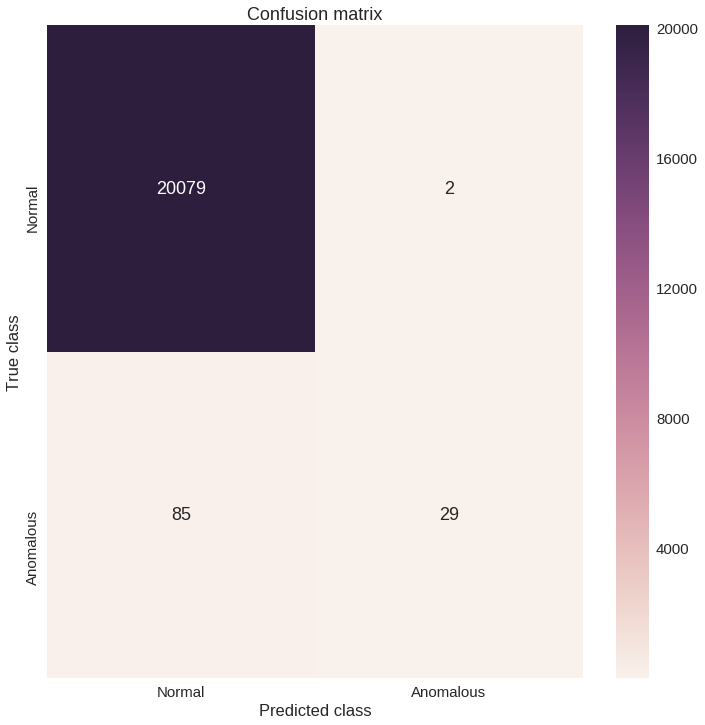

In [35]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# plt.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_CONFMAX.pdf")